In [61]:
import json
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import os.path
from pymrmr import mRMR
import matplotlib.pyplot as plt
from boruta import BorutaPy
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import pandas as pd

# Import raw data

In [62]:
# import data from csv 
cnv = pd.read_csv('dataset_hg19/dataset/cnv.csv', sep=' ')
miRNA = pd.read_csv('dataset_hg19/dataset/mirna.csv', sep=' ')
mRNA = pd.read_csv('dataset_hg19/dataset/mrna.csv', sep=' ')
proteins = pd.read_csv('dataset_hg19/dataset/proteins.csv', sep=' ')

In [63]:
label = pd.read_csv('dataset_hg19/dataset/labels_pfi.csv', sep=' ')

In [64]:
def store_filtered_normalize_data(dataset_dict):
    mkdir_p('filtered_normalize_data')
    filtered_normalize_data = create_data_normalized_filtered(dataset_dict, MinMaxScaler, 0.05)
    for data in dataset_dict:
        filtered_normalize_data[data].to_json('filtered_normalize_data/'+data+'.json')

In [65]:
def load_filtered_normalize_data(dataset_dict):
    dict_test = {}
    if os.path.exists('filtered_normalize_data'):
        for data in dataset_dict:
            with open('filtered_normalize_data/'+data+'.json', 'r') as fp:
                dataset = pd.read_json(fp)
                dict_test[data] = dataset
        return dict_test
    else:
        store_filtered_normalize_data(dataset_dict)
        load_filtered_normalize_data(dataset_dict)

In [66]:
dataset_dict = {'cnv': cnv, 'mirna': miRNA, 'mrna': mRNA, 'proteins': proteins}

datasets = load_filtered_normalize_data(dataset_dict)

# Create concatenation of all dataset

In [67]:
dataset_whole_dataset = pd.concat([datasets['cnv'], datasets['proteins'], datasets['mrna'], datasets['mirna']], axis=1)

In [68]:
datasets['whole_dataset'] = dataset_whole_dataset

# Create concatenation of dataset: proteins+mirna, proteins+mirna+mrna

In [69]:
proteins_mirna_dataset = pd.concat([datasets['proteins'], datasets['mirna']], axis=1)
datasets['proteins_mirna_dataset'] = proteins_mirna_dataset

In [70]:
proteins_mirna_mrna_dataset = pd.concat([datasets['proteins'], datasets['mirna'], datasets['mrna']], axis=1)
datasets['proteins_mirna_mrna_dataset'] = proteins_mirna_mrna_dataset

# Remove correlated feature using R code

In [71]:
robjects.r("""
install.packages('caret')
""")

R[write to console]: Installazione pacchetto in ‘/usr/local/lib/R/site-library’
(perché ‘lib’ non è specificato)

R[write to console]: apertura URL 'https://cloud.r-project.org/src/contrib/caret_6.0-93.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2273775 bytes (2.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

30e 	 0.000
34 	 69 	 hsa-let-7g 	 0.000
35 	 65 	 hsa-mir-187 	 0.000
36 	 61 	 Jak2 	 0.000
37 	 67 	 hsa-mir-1539 	 0.000
38 	 72 	 hsa-mir-454 	 0.000
39 	 70 	 hsa-mir-142 	 0.000
40 	 43 	 hsa-mir-3194 	 0.000
41 	 1 	 hsa-mir-126 	 0.000
42 	 16 	 hsa-mir-500a 	 0.000
43 	 18 	 hsa-mir-612 	 0.000
44 	 14 	 hsa-mir-30b 	 0.000
45 	 12 	 hsa-mir-16-2 	 0.000
46 	 17 	 p38_pT180_Y182 	 0.000
47 	 10 	 hsa-mir-34b 	 0.000
48 	 19 	 hsa-mir-155 	 0.000
49 	 13 	 hsa-mir-24-1 	 0.000
50 	 40 	 hsa-mir-33a 	 0.000
51 	 11 	 hsa-mir-576 	 0.000
52 	 4 	 hsa-mir-19b-2 	 0.000
53 	 7 	 hsa-mir-320a 	 0.000
54 	 3 	 hsa-mir-3617 	 0.000
55 	 41 	 hsa-mir-31 	 0.000
56 	 5 	 PRAS40_pT246 	 0.000
57 	 9 	 hsa-let-7f-1 	 0.000
58 	 8 	 hsa-mir-301a 	 0.000
59 	 20 	 hsa-mir-186 	 0.000
60 	 2 	 hsa-mir-29b-2 	 0.000
61 	 21 	 mTOR 	 0.000
62 	 27 	 hsa-mir-320b-2 	 0.000
63 	 37 	 hsa-mir-1270-2 	 0.000
64 	 32 	 hsa-mir-342 	 0.000
65 	 35 	 hsa-mir-3936 	 0.000
66 	 30 	 hsa-mir-550a-2 	 0

* installing *source* package ‘caret’ ...
** pacchetto ‘caret’ aperto con successo con controllo somme MD5
** using staged installation
** libs
installing to /usr/local/lib/R/site-library/00LOCK-caret/00new/caret/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading


gcc -I"/usr/share/R/include" -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-Faorqz/r-base-4.2.2.20221110=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c caret.c -o caret.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o caret.so caret.o -L/usr/lib/R/lib -lR


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (caret)
R[write to console]: 

R[write to console]: 
R[write to console]: I pacchetti scaricati con il codice sorgente sono in
	‘/tmp/RtmpoveH8K/downloaded_packages’
R[write to console]: 
R[write to console]: 



<rpy2.rinterface.NULLType object at 0x7f575f7958c0> [RTYPES.NILSXP]

In [72]:
robjects.r("""
library(doParallel)
""")

'doParall...,'parallel','iterators',...,'datasets','methods','base'


In [73]:
robjects.r("""
remove_correlated_par <- function(df, dim_split = 1000, maxiter = 5, method = "pearson", cutoff = 0.8){
  
  #df has features on columns
  X = t(df)
  niter = 0
  if (!is.finite(dim_split)) dim_split = nrow(X)
  cat("dim(X) before starting remove correlation: ", dim(X), "\n")
  while(niter < maxiter ){
    cat("niter = ", niter, '\n')
    filtered_X = NULL
    
    cl <- makeCluster(4)
    registerDoParallel(cl)
    
    filtered_X = foreach(nR = seq(1, nrow(X), by=dim_split), 
                         .combine='rbind', .packages = c("caret")) %dopar% {
                           
         subX = X[nR:min(nrow(X), (nR+dim_split-1)), ]
         cc = cor(t(subX), use = "pairwise.complete.obs", method = "kendall")
         
         select_corr = caret::findCorrelation(cc, cutoff = cutoff, exact = FALSE)
         #print(length(select_corr))
         
         if (length(select_corr)>0){ 
           subX = subX[-select_corr, ]
         }
         
         return(subX)
           
     }
    
    stopCluster(cl)
    
    print(names(filtered_X))
    #    if (length(unique(filtered_X[,1]))>1) cat('PROBLEMA!')
    no_removed = nrow(X)-nrow(filtered_X)
    cat('Removed = ', no_removed, '\n')
    cat('dim filetered_X =', dim(filtered_X), '\n')

    X = filtered_X[sample(nrow(filtered_X)), ]
    
    niter = niter + 1
    cat("nrow(X) =", dim(X), '\n')
    if (no_removed ==0) break;
  }
  cat('final dimension = ', dim(t(X)), '\n')
  
  
  return(t(X))
    }
    """)

R object with classes: ('function',) mapped to:

# Convert data in a r structure data

In [74]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins = robjects.conversion.py2rpy(datasets['proteins'])

/home/ale/.local/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:53: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [75]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_miRNA = robjects.conversion.py2rpy(datasets['mirna'])

In [76]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_mRNA = robjects.conversion.py2rpy(datasets['mrna'])

In [77]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_cnv = robjects.conversion.py2rpy(datasets['cnv'])

In [78]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_whole_dataset = robjects.conversion.py2rpy(datasets['whole_dataset'])

In [79]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins_mirna_dataset = robjects.conversion.py2rpy(datasets['proteins_mirna_dataset'])

In [80]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins_mirna_mrna_dataset = robjects.conversion.py2rpy(datasets['proteins_mirna_mrna_dataset'])

# Store data in local

In [81]:
def compute_and_save_result(data, path):
    data_removed = robjects.globalenv["remove_correlated_par"](data)
    df = pd.DataFrame(data=np.array(data_removed), columns=data_removed.colnames)
    df.to_json(path)
    
def restore_result(file_name):
    return pd.read_json(f'elaborated_data_with_r_function/{file_name}.json')

def load_or_store_removed_correlated(data, file_name):
    if os.path.exists(f'elaborated_data_with_r_function/{file_name}.json'):
        return restore_result(file_name)
    else:
        compute_and_save_result(data, f'elaborated_data_with_r_function/{file_name}.json')
        return restore_result(file_name)

In [82]:
df_proteins_removed = load_or_store_removed_correlated(r_proteins, 'r_proteins_removed')

In [83]:
df_mirna_removed = load_or_store_removed_correlated(r_miRNA, 'r_mirna_removed')

In [84]:
df_mrna_removed = load_or_store_removed_correlated(r_mRNA, 'r_mrna_removed')

In [85]:
df_cnv_removed = load_or_store_removed_correlated(r_cnv, 'r_cnv_removed')

In [86]:
df_dataset_whole_dataset_removed = load_or_store_removed_correlated(r_whole_dataset, 'r_dataset_whole_dataset_removed')

In [87]:
df_dataset_proteins_mirna_removed = load_or_store_removed_correlated(r_proteins_mirna_dataset, 'r_proteins_mirna_dataset_removed')

In [88]:
df_dataset_proteins_mirna_mrna_removed = load_or_store_removed_correlated(r_proteins_mirna_mrna_dataset, 'r_proteins_mirna_mrna_dataset_removed')

In [89]:
print('DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE')

DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE


# Mann-Whitney

In [90]:
def create_dataframe_pos_neg(dataset, label):
    mask_1 = label['x']==1
    mask_0 = label['x']==0
    return (dataset[mask_1.values], dataset[mask_0.values])

In [91]:
def mann_whitney_features_selection(dataset, label, min_pValue):
    pos, neg = create_dataframe_pos_neg(dataset, label)
    H, pval = mannwhitneyu(pos, neg)
    mask = (pval < min_pValue)
    return dataset.columns[mask]

# Multivariate feature selection, mrmr and Boruta 

In [92]:
def execute_mrmr(dataset, n_feature):
    return mRMR(dataset, 'MIQ', n_feature)

In [93]:
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    max_iter: int = 100,
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """

    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5)
    
    boruta_selector = BorutaPy(
        model,
        n_estimators='auto',
        verbose=False,
        alpha=0.05,
        max_iter=max_iter, 
        random_state=42,
    )
    boruta_selector.fit(X_train.values, y_train.values.ravel())
    
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    return kept_features, discarded_features

# Train on fold

In [94]:
def train_using_mann_whitney_on_fold(X,
                            label, 
                            num_external_fold,
                            type_dataset, 
                            tecnique_feature_selection,
                            path):
    
    _, ax = plt.subplots(figsize=(10, 10))
    average_precision_scores =[]
    y_score_concatenated = []
    y_test_fold_concatenated = []
    y_predicted_concatenated = []
    list_selected_feature = {}
    iterator = 0
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {} 
    
   
    X_numpy = X.values
    label_numpy = label['x'].values
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X_numpy[train_index], X_numpy[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        df_X_train = pd.DataFrame(data=X_train_fold, columns=X.columns)
        df_X_test = pd.DataFrame(data=X_test_fold, columns=X.columns)
        df_y_train = pd.DataFrame(data=y_train_fold, columns=label.columns)
        
        selected_features = mann_whitney_features_selection(df_X_train, df_y_train, 0.05)
        
        list_selected_feature[iterator] = selected_features
        
        X_train_selected_feature = df_X_train[selected_features]
        X_test_selected_feature = df_X_test[selected_features]
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_selected_feature, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_selected_feature)[:, 1]
        
        # get the prediction
        y_predicted = clf.predict(X_test_fold)
        y_predicted_concatenated = np.concatenate((y_predicted_concatenated, y_predicted), axis=None)
        
        avg_precision_score = average_precision_score(y_test_fold, y_score)
        average_precision_scores.append(avg_precision_score)
        
        #concatenation of result for external AUPRC
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
               
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score, ax=ax,name=f'Result on {iterator} fold:')

        plt.title('AUPRC Internal')
        ax.legend(title='AUPRC_score')
        
        iterator = iterator +1
        plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_AUPRC_Internal.pdf')
    
    internal_average_precision_score = np.mean(average_precision_scores)
    
    external_average_precision_score = average_precision_score(y_test_fold_concatenated, y_score_concatenated)
    
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated,name='Concat of predictions')

    plt.title('AUPRC external')
    plt.legend(title='AUPRC_score')
    plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_External.pdf')
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    result_dict[type_dataset][tecnique_feature_selection]['feature_used'] = str(list_selected_feature)
    
    #confusion matrix external
    cm = confusion_matrix(y_test_fold_concatenated, y_predicted_concatenated, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    disp.figure_.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+f'ConfusionMatrixTotal.pdf')
    
    tn, fp, fn, tp = confusion_matrix(y_test_fold_concatenated, y_predicted_concatenated).ravel()
    specificity = tn / (tn+fp)
    print(f'Specificity: {specificity}')
    print(classification_report(y_test_fold_concatenated, y_predicted_concatenated, target_names=['class 0', 'class 1']))
      
    with open(path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4) 
    
    return list_selected_feature

# GridSearch

In [95]:
model_selection_grid_DT = [
    {'criterion': ['gini', 'entropy'],
     'max_leaf_nodes': [None, 2, 5, 10],
     'max_features': [None, 'sqrt', 'log2'],
    'n_estimators': [51, 101, 251, 500]}
]

# Train using multivariate feature selection after mannwhitney on fold

In [36]:
def train_using_multivariate_on_fold(X,
                             label,
                             list_selected_feature_from_mannwhiney, 
                             num_external_fold,
                             tecnique_feature_selection,
                             path,
                             type_dataset,
                             type_feature_selection=None):
    _, ax = plt.subplots(figsize=(10, 10))
    average_precision_scores =[]
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    list_selected_feature = {}
    iterator = 0
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {}
    
    X_numpy = X.values
    label_numpy = label['x'].values
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for (train_index, test_index), selected_features in zip(tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False), list_selected_feature_from_mannwhiney.values()):
        
        X_train_fold, X_test_fold = X_numpy[train_index], X_numpy[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        df_X_train = pd.DataFrame(data=X_train_fold, columns=X.columns)
        df_X_test = pd.DataFrame(data=X_test_fold, columns=X.columns)
        df_y_train = pd.DataFrame(data=y_train_fold, columns=label.columns)
        
        #TAKE FEATURES FROM MANNWHINEY
        X_train_selected_feature = df_X_train[selected_features]
        X_test_selected_feature = df_X_test[selected_features]
       
        if type_feature_selection == "mrmr":
            selected_features = execute_mrmr(X_train_selected_feature, 100)
        elif type_feature_selection == 'boruta':
            selected_features, discarded_feature =  execute_boruta_feature_selection(X_train_selected_feature, df_y_train, 5)
        
        list_selected_feature[iterator] = selected_features
        
        
        X_train_selected_feature = X_train_selected_feature[selected_features]
        X_test_selected_feature = X_test_selected_feature[selected_features]
        
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_selected_feature, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_selected_feature)[:, 1]
        
        avg_precision_score = average_precision_score(y_test_fold, y_score)
        average_precision_scores.append(avg_precision_score)
        
        #concatenation of result for external AUPRC
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
               
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score, ax=ax,name=f'Result on {iterator} fold:')

        plt.title('Random_Forest internal')
        ax.legend(title='AUPRC')
        
        plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_AUPRC_Internal.pdf')
        
        iterator = iterator + 1
        
    internal_average_precision_score = np.mean(average_precision_scores)
    
    external_average_precision_score = average_precision_score(y_test_fold_concatenated, y_score_concatenated)

    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated,name='Concat of predictions')
    plt.title('Random_Forest external')
    plt.legend(title='AUPRC')
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    result_dict[type_dataset][tecnique_feature_selection]['feature_used'] = str(list_selected_feature)
    
    plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_External.pdf')
    
    with open('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    
    return list_selected_feature

# Train proteins

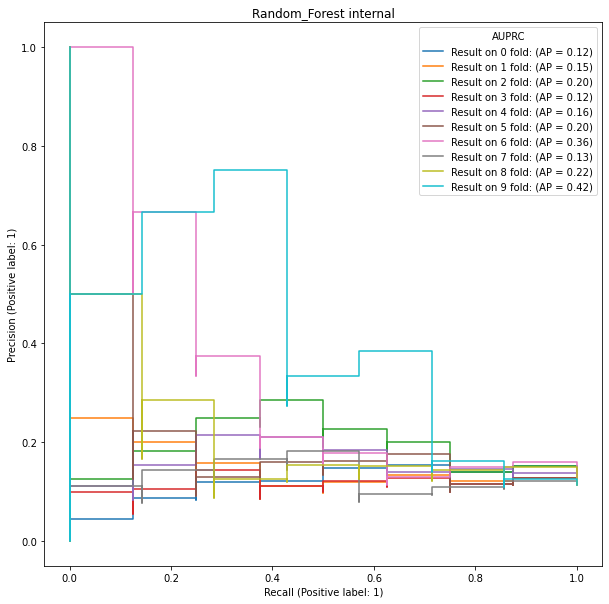

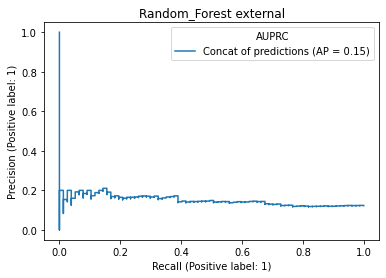

In [37]:
!mkdir 'Result_new/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold'
!mkdir 'Result_new/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/r_function_with_mannwhitney'
list_selected_feature_proteins = train_using_mann_whitney_on_fold(
    df_proteins_removed, label, 10, 'proteins', 'r_function_with_mannwhitney',
    'Result_new/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/')

Running fold : 2it [00:13,  6.74s/it]



 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 15 	 Bcl-2 	 0.019
2 	 12 	 ERK2 	 0.019
3 	 5 	 Bak 	 0.019
4 	 7 	 Annexin_VII 	 0.019
5 	 10 	 PREX1 	 0.000
6 	 13 	 Shc_pY317 	 0.000
7 	 11 	 B-Raf_pS445 	 0.000
8 	 8 	 p27 	 0.000
9 	 2 	 PI3K-p110-alpha 	 0.000
10 	 6 	 Fibronectin 	 0.000
11 	 4 	 mTOR 	 0.000
12 	 3 	 Raptor 	 0.000
13 	 9 	 Jak2 	 0.000
14 	 14 	 XRCC1 	 0.000

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 15 	 Bcl-2 	 0.019
2 	 12 	 ERK2 	 0.995
3 	 5 	 Bak 	 0.995
4 	 7 	 Annexin_VII 	 0.

Running fold : 5it [00:33,  6.75s/it]

17 	 7 	 E-Cadherin 	 0.000
18 	 17 	 MIG-6 	 0.000
19 	 2 	 Raptor 	 0.000


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 19 	 Ku80 	 0.000
2 	 20 	 STAT5-alpha 	 0.000
3 	 16 	 p38_pT180_Y182 	 0.000
4 	 17 	 XRCC1 	 0.000
5 	 18 	 Akt_pS473 	 0.000
6 	 14 	 Shc_pY317 	 0.000
7 	 12 	 PREX1 	 0.000
8 	 21 	 MEK1_pS217_S221 	 0.000
9 	 22 	 Bcl-2 	 0.000
10 	 23 	 4E-BP1_pS65 	 0.000
11 	 15 	 YB-1_pS102 	 0.000
12 	 1 	 MAPK_pT202_Y204 	 0.000
13 	 13 	 ERK2 	 0.000
14 	 6 	 S6_pS240_S244 	 0.000
15 	 7 	 Akt_pT308 	 0.0

Running fold : 9it [01:02,  7.02s/it]

0


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 8 	 PREX1 	 0.000
2 	 6 	 Cyclin_B1 	 0.000
3 	 11 	 MEK1_pS217_S221 	 0.000
4 	 10 	 XRCC1 	 0.000
5 	 9 	 ERK2 	 0.000
6 	 1 	 GSK3_pS9 	 0.000
7 	 7 	 Jak2 	 0.000
8 	 2 	 Raptor 	 0.000
9 	 5 	 p27 	 0.000
10 	 4 	 eIF4E 	 0.000
11 	 3 	 mTOR 	 0.000

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 8 	 PREX1 	 0.000
2 	 6 	 Cyclin_B1 	 0.043
3 	 11 	 MEK1_pS217_S221 	 0.043
4 	 10 	 XRCC1 	 0.043
5 	 9 	 ERK2 	 0.043
6 	 1 	 GSK3_pS9 	 0.043
7 	 7 	 Jak2 	 0.043
8 

{0: ['Bcl-2',
  'ERK2',
  'Bak',
  'Annexin_VII',
  'PREX1',
  'Shc_pY317',
  'B-Raf_pS445',
  'p27',
  'PI3K-p110-alpha',
  'Fibronectin',
  'mTOR',
  'Raptor',
  'Jak2',
  'XRCC1',
  'PRAS40_pT246',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',
  'DJ-1',

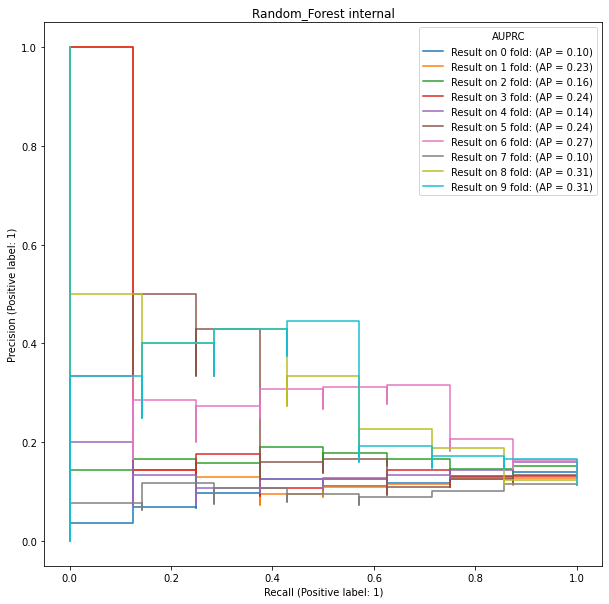

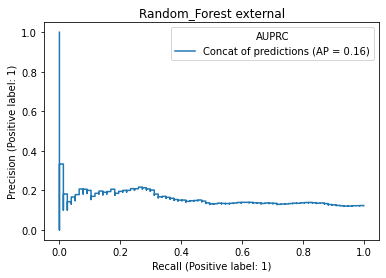

In [38]:
!mkdir 'Result/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/r_function_with_mannwhitney_mrmr'
train_using_multivariate_on_fold(df_proteins_removed, label, list_selected_feature_proteins, 10,
                         'r_function_with_mannwhitney_mrmr', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'proteins',
                         'mrmr')

{0: ['PRAS40_pT246', 'PI3K-p110-alpha', 'Annexin_VII', 'p27', 'Shc_pY317'],
 1: ['PRAS40_pT246', 'mTOR_pS2448', 'mTOR', 'p27', 'XRCC1', '4E-BP1_pS65'],
 2: ['mTOR', 'p27', 'MIG-6'],
 3: ['PRAS40_pT246', 'mTOR', 'p27', 'Jak2', 'Ku80'],
 4: ['PRAS40_pT246', 'eIF4E', 'p27', 'Jak2', 'Shc_pY317', 'XRCC1'],
 5: ['PRAS40_pT246', 'GSK3_pS9', 'p27'],
 6: ['mTOR', 'eIF4E', 'p27'],
 7: ['PRAS40_pT246', 'mTOR', 'p27', 'B-Raf_pS445'],
 8: ['mTOR', 'p27', 'Jak2', 'PREX1', 'Shc_pY317'],
 9: ['PRAS40_pT246', 'mTOR', 'Jak2', 'Shc_pY317']}

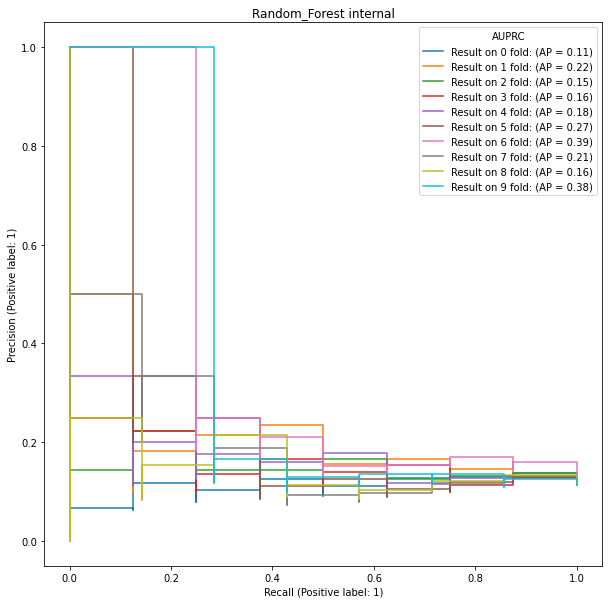

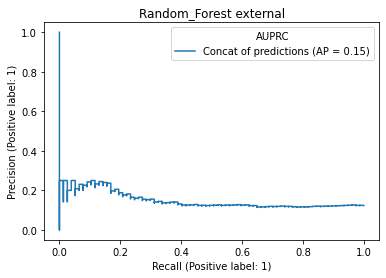

In [39]:
!mkdir 'Result/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/r_function_with_mannwhitney_boruta'
train_using_multivariate_on_fold(df_proteins_removed, label, list_selected_feature_proteins, 10,
                         'r_function_with_mannwhitney_boruta', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'proteins',
                         'boruta')

# Train miRNA 

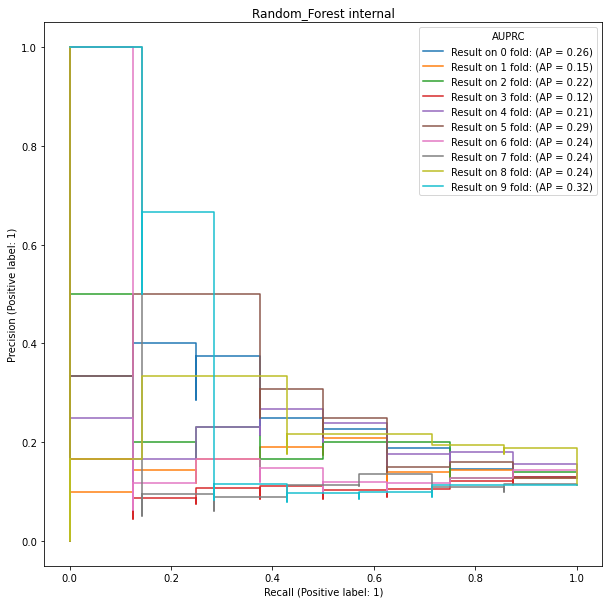

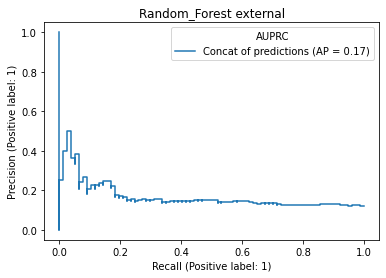

In [40]:
list_selected_feature_mirna = train_using_mann_whitney_on_fold(
    df_mirna_removed, label, 10, 'mirna', 'r_function_with_mannwhitney',
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/')

Running fold : 0it [00:00, ?it/s]

83_pY185 	 0.000
9 	 5 	 FASN 	 0.000
10 	 4 	 mTOR 	 0.000
11 	 3 	 beta-Catenin 	 0.000
12 	 13 	 Ku80 	 0.000

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 9 	 Jak2 	 0.000
2 	 7 	 A-Raf 	 0.043
3 	 12 	 XRCC1 	 0.043
4 	 11 	 p38_pT180_Y182 	 0.043
5 	 10 	 Shc_pY317 	 0.043
6 	 1 	 Raptor 	 0.043
7 	 2 	 TAZ 	 0.043
8 	 6 	 JNK_pT183_pY185 	 0.043
9 	 5 	 FASN 	 0.043
10 	 4 	 mTOR 	 0.043
11 	 3 	 beta-Catenin 	 0.043
12 	 13 	 Ku80 	 0.043
13 	 8 	 p27 	 0.000


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 

Running fold : 1it [00:08,  8.46s/it]

 hsa-mir-28 	 0.009
48 	 27 	 hsa-mir-660 	 0.009
49 	 21 	 hsa-let-7f-1 	 0.009
50 	 7 	 hsa-mir-20a 	 0.005
51 	 39 	 hsa-mir-320b-2 	 0.000
52 	 13 	 hsa-mir-3936 	 0.000
53 	 53 	 hsa-mir-3194 	 0.000
54 	 54 	 hsa-mir-186 	 0.000
55 	 16 	 hsa-mir-320a 	 0.000


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 56 	 hsa-mir-3154 	 0.000
2 	 12 	 hsa-mir-3180-3 	 0.000
3 	 15 	 hsa-mir-1234 	 0.000
4 	 37 	 hsa-mir-623 	 0.000
5 	 19 	 hsa-mir-4254 	 0.000
6 	 50 	 hsa-mir-320b-2 	 0.000
7 	 41 	 hsa-mir-3683 	 0.000
8 	 54

Running fold : 2it [00:21, 11.37s/it]

hsa-mir-21 	 0.043
39 	 32 	 hsa-mir-1291 	 0.043
40 	 30 	 hsa-mir-15a 	 0.043
41 	 29 	 hsa-let-7f-1 	 0.043
42 	 28 	 hsa-mir-1277 	 0.043
43 	 25 	 hsa-mir-19b-2 	 0.043
44 	 66 	 hsa-mir-191 	 0.011
45 	 70 	 hsa-mir-186 	 0.011
46 	 18 	 hsa-mir-3936 	 0.012
47 	 8 	 hsa-mir-30b 	 0.011
48 	 22 	 hsa-mir-454 	 0.009
49 	 24 	 hsa-mir-16-2 	 0.009
50 	 71 	 hsa-mir-181d 	 0.009
51 	 7 	 hsa-mir-155 	 0.009
52 	 59 	 hsa-mir-33a 	 0.010
53 	 16 	 hsa-mir-126 	 0.010
54 	 60 	 hsa-mir-92a-1 	 0.010
55 	 1 	 hsa-let-7i 	 0.010
56 	 9 	 hsa-mir-135a-1 	 0.010
57 	 35 	 hsa-mir-29b-2 	 0.010
58 	 52 	 hsa-mir-500a 	 0.010
59 	 23 	 hsa-mir-320a 	 0.011
60 	 3 	 hsa-mir-1252 	 0.007
61 	 11 	 hsa-mir-550a-1 	 0.006
62 	 13 	 hsa-mir-20a 	 0.006
63 	 27 	 hsa-mir-98 	 0.006
64 	 6 	 hsa-mir-363 	 0.005
65 	 51 	 hsa-mir-664 	 0.000
66 	 40 	 hsa-mir-28 	 0.000
67 	 26 	 hsa-mir-320c-1 	 0.000
68 	 5 	 hsa-mir-514-2 	 0.000
69 	 48 	 hsa-mir-30e 	 0.000
70 	 58 	 hsa-mir-374a 	 0.000
71 	

Running fold : 3it [00:35, 12.35s/it]

 	 0.000
85 	 28 	 hsa-mir-769 	 0.000
86 	 33 	 hsa-mir-19b-2 	 0.000
87 	 34 	 hsa-mir-320c-1 	 0.000
88 	 32 	 hsa-mir-16-2 	 0.000
89 	 29 	 hsa-mir-454 	 0.000
90 	 31 	 hsa-mir-3126 	 0.000
91 	 98 	 hsa-mir-181d 	 0.000
92 	 35 	 hsa-mir-98 	 0.000
93 	 36 	 hsa-mir-1277 	 0.000
94 	 30 	 hsa-mir-320a 	 0.000
95 	 73 	 hsa-mir-556 	 0.000
96 	 45 	 hsa-mir-34b 	 0.000
97 	 87 	 hsa-mir-141 	 0.000

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 49 	 hsa-mir-29a 	 0.019
2 	 16 	 hsa-mir-1234 	 0.154
3 	 41 	 hsa-mir-30c-1 	 0.074
4 	 61 	 hsa-mir-4279 	 0.075
5 	 23 	 hsa-mir-1260b 	 0.075
6 	 68 	 hsa-mir-3942 	 0.041
7 	 67 	 hsa-mir-664 	 0.042
8 	 71 	 hsa-mir-887 	 0.042
9 	 70 	 hsa-mir-3913-2 	 0.042
10 	 63 	 hsa-mir-513c 	 0.042
11 	 66 	 hsa-mir-320b-2 	 0.042
12 	 74 	 hsa-mir-101-1 	 0.042
13 	 65 	 hsa-mir-642a 	 0.043
14 	 57 	 hsa-mir-662 	 0.043
15 	 58 	 hsa-mir-93 	 0.043
16 	 55 	 hsa-mir-34a 	 0.043
17 	 56 	 hsa-mir-342 	 0.043
18 	 64 	 hsa-mir-3165 	

Running fold : 4it [00:48, 12.65s/it]

hsa-mir-17 	 0.000
43 	 76 	 hsa-mir-556 	 0.000
44 	 85 	 hsa-mir-92a-1 	 0.000
45 	 82 	 hsa-mir-653 	 0.000
46 	 83 	 hsa-mir-33b 	 0.000
47 	 84 	 hsa-mir-33a 	 0.000
48 	 52 	 hsa-mir-660 	 0.000
49 	 1 	 hsa-let-7i 	 0.000
50 	 50 	 hsa-mir-34b 	 0.000
51 	 18 	 hsa-mir-1234 	 0.000
52 	 19 	 hsa-mir-126 	 0.000
53 	 15 	 hsa-mir-550a-1 	 0.000
54 	 16 	 hsa-mir-20a 	 0.000
55 	 17 	 hsa-mir-362 	 0.000
56 	 13 	 hsa-mir-130a 	 0.000
57 	 12 	 hsa-mir-1292 	 0.000
58 	 20 	 hsa-mir-3650 	 0.000
59 	 21 	 hsa-mir-497 	 0.000
60 	 22 	 hsa-mir-148a 	 0.000
61 	 14 	 hsa-mir-489 	 0.000
62 	 25 	 hsa-mir-3613 	 0.000
63 	 6 	 hsa-mir-339 	 0.000
64 	 7 	 hsa-mir-514-2 	 0.000
65 	 3 	 hsa-mir-564 	 0.000
66 	 4 	 hsa-mir-1252 	 0.000
67 	 5 	 hsa-mir-3188 	 0.000
68 	 26 	 hsa-mir-142 	 0.000
69 	 11 	 hsa-mir-135a-1 	 0.000
70 	 8 	 hsa-mir-155 	 0.000
71 	 9 	 hsa-mir-30b 	 0.000
72 	 10 	 hsa-mir-192 	 0.000
73 	 23 	 hsa-mir-3936 	 0.000
74 	 2 	 hsa-mir-101-2 	 0.000
75 	 43 	 

Running fold : 5it [00:57, 11.29s/it]

-130a 	 0.000
63 	 36 	 hsa-mir-660 	 0.000
64 	 59 	 hsa-mir-592 	 0.000
65 	 14 	 hsa-mir-126 	 0.000
66 	 32 	 hsa-mir-181c 	 0.000
67 	 39 	 hsa-mir-659 	 0.000

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 27 	 hsa-mir-1322 	 0.000
2 	 62 	 hsa-mir-567 	 0.074
3 	 13 	 hsa-mir-1234 	 0.087
4 	 61 	 hsa-mir-3178 	 0.061
5 	 34 	 hsa-mir-623 	 0.064
6 	 18 	 hsa-mir-4254 	 0.067
7 	 43 	 hsa-mir-4279 	 0.068
8 	 47 	 hsa-mir-320b-2 	 0.039
9 	 46 	 hsa-mir-1293 	 0.040
10 	 40 	 hsa-mir-342 	 0.040
11 	 49 	 hsa-mir-3913-2 	 0.040
12 	 48 	 hsa-mir-664 	 0.041
13 	 44 	 hsa-mir-30e 	 0.041
14 	 41 	 hsa-mir-662 	 0.041
15 	 45 	 hsa-mir-513c 	 0.041
16 	 42 	 hsa-mir-3170 	 0.041
17 	 53 	 hsa-mir-643 	 0.042
18 	 50 	 hsa-mir-496 	 0.042
19 	 51 	 hsa-mir-556 	 0.042
20 	 63 	 hsa-mir-191 	 0.042
21 	 67 	 hsa-mir-186 	 0.042
22 	 66 	 hsa-mir-3194 	 0.042
23 	 65 	 hsa-mir-20b 	 0.042
24 	 64 	 hsa-mir-550a-2 	 0.042
25 	 52 	 hsa-mir-26b 	 0.042
26 	 58 	 hsa-mir-3162 	 

Running fold : 6it [01:08, 11.13s/it]

sa-mir-342 	 0.000
44 	 1 	 hsa-let-7i 	 0.000
45 	 19 	 hsa-mir-3202-1 	 0.000
46 	 22 	 hsa-mir-142 	 0.000
47 	 17 	 hsa-mir-126 	 0.000
48 	 15 	 hsa-mir-362 	 0.000
49 	 20 	 hsa-mir-148a 	 0.000
50 	 13 	 hsa-mir-20a 	 0.000
51 	 23 	 hsa-mir-19b-1 	 0.000
52 	 16 	 hsa-mir-1234 	 0.000
53 	 25 	 hsa-mir-502 	 0.000
54 	 5 	 hsa-mir-514-2 	 0.000
55 	 9 	 hsa-mir-1292 	 0.000
56 	 4 	 hsa-mir-339 	 0.000
57 	 24 	 hsa-mir-200c 	 0.000
58 	 8 	 hsa-mir-187 	 0.000
59 	 11 	 hsa-mir-550a-1 	 0.000
60 	 10 	 hsa-mir-130a 	 0.000
61 	 2 	 hsa-mir-101-2 	 0.000
62 	 44 	 hsa-mir-659 	 0.000
63 	 41 	 hsa-mir-3664 	 0.000
64 	 37 	 hsa-mir-103-2 	 0.000
65 	 26 	 hsa-mir-320a 	 0.000
66 	 33 	 hsa-let-7f-1 	 0.000
67 	 36 	 hsa-mir-29b-2 	 0.000
68 	 42 	 hsa-mir-660 	 0.000
69 	 39 	 hsa-mir-34b 	 0.000
70 	 35 	 hsa-mir-181c 	 0.000
71 	 40 	 hsa-mir-185 	 0.000
72 	 28 	 hsa-mir-16-2 	 0.000
73 	 30 	 hsa-mir-98 	 0.000
74 	 27 	 hsa-mir-3126 	 0.000
75 	 85 	 hsa-mir-186 	 0.000
76

Running fold : 7it [01:16, 10.33s/it]

00
62 	 8 	 hsa-mir-489 	 0.000


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 15 	 hsa-mir-1234 	 0.000
2 	 20 	 hsa-mir-4254 	 0.000
3 	 53 	 hsa-mir-4279 	 0.000
4 	 78 	 hsa-mir-3178 	 0.000
5 	 59 	 hsa-mir-500a 	 0.000
6 	 57 	 hsa-mir-576 	 0.000
7 	 54 	 hsa-mir-30e 	 0.000
8 	 61 	 hsa-mir-147b 	 0.000
9 	 62 	 hsa-mir-3913-2 	 0.000
10 	 63 	 hsa-mir-887 	 0.000
11 	 58 	 hsa-mir-664 	 0.000
12 	 65 	 hsa-mir-26b 	 0.000
13 	 46 	 hsa-mir-95 	 0.000
14 	 50 	 hsa-mir-93 	 0.000
15 	 45 	 hsa-mir-28 	 0.000
16 	 5

Running fold : 8it [01:27, 10.50s/it]

9 	 hsa-mir-3936 	 0.043
34 	 17 	 hsa-mir-519c 	 0.043
35 	 13 	 hsa-mir-548s 	 0.043
36 	 21 	 hsa-mir-142 	 0.043
37 	 5 	 hsa-mir-514-2 	 0.043
38 	 9 	 hsa-mir-130a 	 0.043
39 	 23 	 hsa-mir-30c-2 	 0.043
40 	 36 	 hsa-mir-21 	 0.043
41 	 35 	 hsa-mir-1291 	 0.043
42 	 37 	 hsa-mir-181c 	 0.043
43 	 34 	 hsa-mir-24-1 	 0.043
44 	 39 	 hsa-mir-623 	 0.043
45 	 40 	 hsa-mir-196a-2 	 0.043
46 	 31 	 hsa-mir-1277 	 0.043
47 	 27 	 hsa-mir-3126 	 0.043
48 	 28 	 hsa-mir-16-2 	 0.043
49 	 29 	 hsa-mir-19b-2 	 0.043
50 	 44 	 hsa-mir-509-1 	 0.012
51 	 7 	 hsa-mir-30b 	 0.012
52 	 61 	 hsa-mir-147b 	 0.011
53 	 84 	 hsa-mir-181d 	 0.010
54 	 6 	 hsa-mir-155 	 0.010
55 	 38 	 hsa-mir-29b-2 	 0.010
56 	 16 	 hsa-mir-126 	 0.010
57 	 14 	 hsa-mir-362 	 0.010
58 	 12 	 hsa-mir-20a 	 0.010
59 	 70 	 hsa-mir-33a 	 0.011
60 	 41 	 hsa-mir-34b 	 0.011
61 	 50 	 hsa-mir-93 	 0.011
62 	 26 	 hsa-mir-320a 	 0.011
63 	 25 	 hsa-mir-454 	 0.011
64 	 45 	 hsa-mir-28 	 0.011
65 	 83 	 hsa-mir-186 	 0.0

Running fold : 9it [01:36,  9.95s/it]

 	 46 	 hsa-mir-20b 	 0.042
19 	 41 	 hsa-mir-31 	 0.042
20 	 40 	 hsa-mir-3162 	 0.042
21 	 29 	 hsa-mir-513c 	 0.042
22 	 1 	 hsa-mir-101-2 	 0.042
23 	 27 	 hsa-mir-3617 	 0.042
24 	 5 	 hsa-mir-155 	 0.042
25 	 9 	 hsa-mir-362 	 0.042
26 	 8 	 hsa-mir-548s 	 0.042
27 	 13 	 hsa-mir-148a 	 0.042
28 	 4 	 hsa-mir-514-2 	 0.042
29 	 3 	 hsa-mir-339 	 0.042
30 	 26 	 hsa-mir-662 	 0.042
31 	 21 	 hsa-mir-1291 	 0.042
32 	 19 	 hsa-mir-1277 	 0.042
33 	 17 	 hsa-mir-19b-2 	 0.043
34 	 16 	 hsa-mir-16-2 	 0.043
35 	 48 	 hsa-mir-186 	 0.043
36 	 22 	 hsa-mir-29b-2 	 0.011
37 	 25 	 hsa-mir-659 	 0.011
38 	 12 	 hsa-mir-513a-2 	 0.010
39 	 39 	 hsa-mir-92a-1 	 0.008
40 	 11 	 hsa-mir-126 	 0.008
41 	 44 	 hsa-mir-550a-2 	 0.008
42 	 6 	 hsa-mir-489 	 0.008
43 	 45 	 hsa-mir-129-2 	 0.008
44 	 15 	 hsa-mir-320a 	 0.008
45 	 24 	 hsa-mir-34b 	 0.009
46 	 2 	 hsa-mir-1252 	 0.006
47 	 7 	 hsa-mir-550a-1 	 0.005
48 	 20 	 hsa-let-7f-1 	 0.005


 *** This program and the respective minimum Red

{0: ['hsa-mir-1234',
  'hsa-mir-657',
  'hsa-mir-4254',
  'hsa-mir-548s',
  'hsa-mir-4279',
  'hsa-mir-623',
  'hsa-mir-513c',
  'hsa-mir-3617',
  'hsa-mir-500a',
  'hsa-mir-3913-2',
  'hsa-mir-30e',
  'hsa-mir-508',
  'hsa-mir-519b',
  'hsa-mir-3942',
  'hsa-mir-662',
  'hsa-mir-592',
  'hsa-mir-33a',
  'hsa-mir-20b',
  'hsa-mir-19a',
  'hsa-mir-556',
  'hsa-mir-548q',
  'hsa-mir-26b',
  'hsa-mir-101-2',
  'hsa-mir-659',
  'hsa-mir-130a',
  'hsa-mir-148a',
  'hsa-mir-181d',
  'hsa-mir-155',
  'hsa-mir-514-2',
  'hsa-mir-339',
  'hsa-mir-142',
  'hsa-mir-1291',
  'hsa-mir-29b-2',
  'hsa-mir-16-2',
  'hsa-mir-1539',
  'hsa-mir-1277',
  'hsa-mir-19b-2',
  'hsa-mir-653',
  'hsa-mir-1252',
  'hsa-mir-616',
  'hsa-mir-181c',
  'hsa-mir-92a-1',
  'hsa-mir-550a-2',
  'hsa-mir-362',
  'hsa-mir-34b',
  'hsa-mir-126',
  'hsa-mir-28',
  'hsa-mir-660',
  'hsa-let-7f-1',
  'hsa-mir-20a',
  'hsa-mir-320b-2',
  'hsa-mir-3936',
  'hsa-mir-3194',
  'hsa-mir-186',
  'hsa-mir-320a',
  'hsa-let-7g',
  'hs

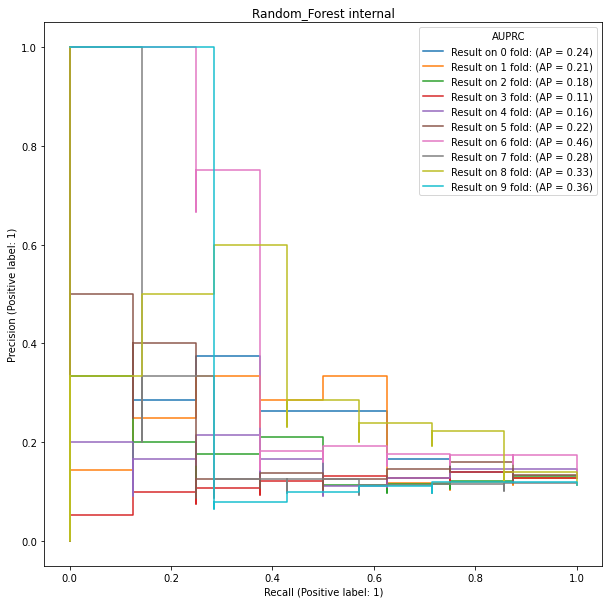

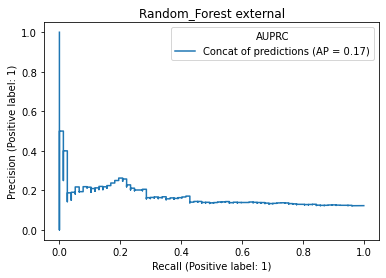

In [41]:
train_using_multivariate_on_fold(df_mirna_removed, label, list_selected_feature_mirna, 10,
                         'r_function_with_mannwhitney_mrmr', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'mirna',
                         'mrmr')

{0: ['hsa-mir-142', 'hsa-mir-653'],
 1: ['hsa-let-7g'],
 2: ['hsa-mir-29b-2'],
 3: ['hsa-let-7g', 'hsa-mir-130a', 'hsa-mir-29b-2'],
 4: ['hsa-let-7g', 'hsa-mir-29b-2'],
 5: ['hsa-let-7g', 'hsa-mir-155', 'hsa-mir-142', 'hsa-mir-505'],
 6: ['hsa-mir-20b'],
 7: ['hsa-mir-142'],
 8: ['hsa-mir-155'],
 9: ['hsa-let-7g', 'hsa-mir-362', 'hsa-mir-29b-2']}

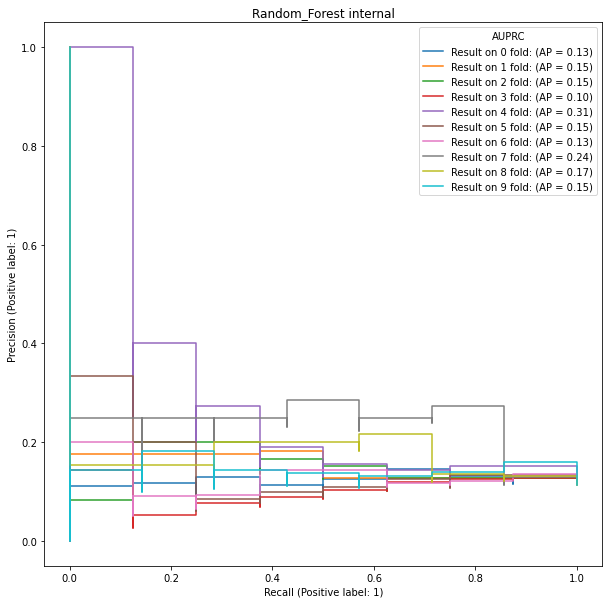

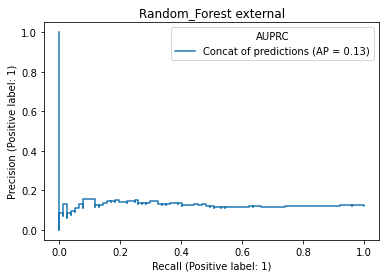

In [42]:
train_using_multivariate_on_fold(df_mirna_removed, label, list_selected_feature_mirna, 10,
                         'r_function_with_mannwhitney_boruta', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'mirna',
                         'boruta')

# Train mrna

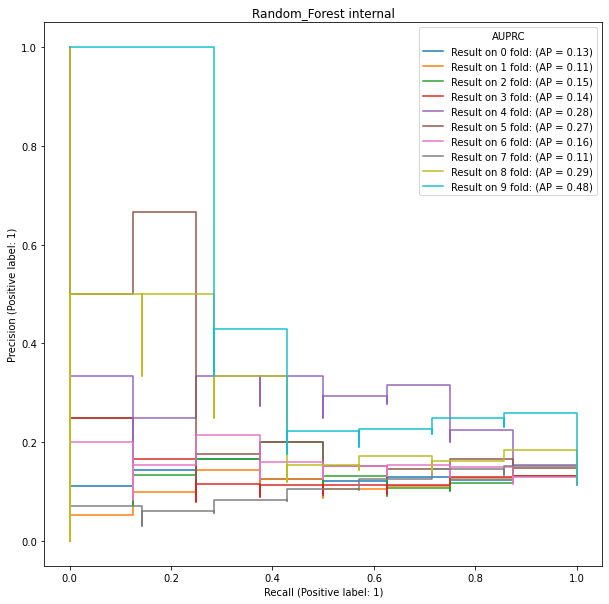

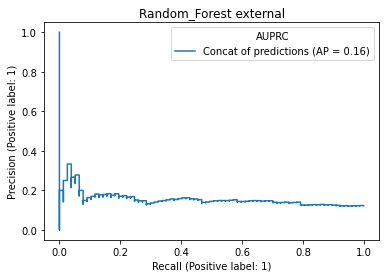

In [43]:
list_selected_feature_mrna = train_using_mann_whitney_on_fold(
    df_mrna_removed, label, 10, 'mrna', 'r_function_with_mannwhitney',
    'Result_new/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/')

train_using_multivariate_on_fold(df_mrna_removed, label, list_selected_feature_mrna, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'mrna',
                         'mrmr')

{0: ['HERPUD1',
  'LOC284009',
  'BCAS4',
  'ACSF2',
  'PRSS45',
  'C3orf62',
  'GNG4',
  'RTP4',
  'ITM2C',
  'LOC96610',
  'LOC648740',
  'PABPC1L',
  'LRRC48',
  'FASLG',
  'ATAD3C',
  'TTC36',
  'C17orf95',
  'C6orf226',
  'LOC100287227',
  'SRRM5',
  'POU2AF1',
  'FLJ40330',
  'CATSPER2',
  'DERL3'],
 1: ['LOC284009',
  'C20orf132',
  'SNX15',
  'C1orf104',
  'ACSF2',
  'AFG3L1',
  'PRSS45',
  'MARVELD3',
  'LOC648740',
  'ATAD3C',
  'TTC36',
  'C1orf213',
  'LOC100130015',
  'C6orf226',
  'SRRM5',
  'FLJ40330'],
 2: ['LOC284009',
  'AFG3L1',
  'MYH14',
  'GOLGA8B',
  'LOC648740',
  'PABPC1L',
  'EPS8L2',
  'TTC36',
  'C6orf226',
  'NCRNA00173',
  'GRIN2C',
  'SRRM5',
  'FLJ40330'],
 3: ['LOC284009',
  'ANGPTL6',
  'SPR',
  'SNX15',
  'ACSF2',
  'C3orf62',
  'PABPC1L',
  'SPTBN4',
  'PCDHB2',
  'TTC36',
  'LOC100130015',
  'C6orf226',
  'FN3K',
  'FLJ40330'],
 4: ['LOC284009',
  'ANGPTL6',
  'SNX15',
  'BCAS4',
  'ACSF2',
  'FAM164C',
  'ENOSF1',
  'PABPC1L',
  'GP6',
  'TTC36',
 

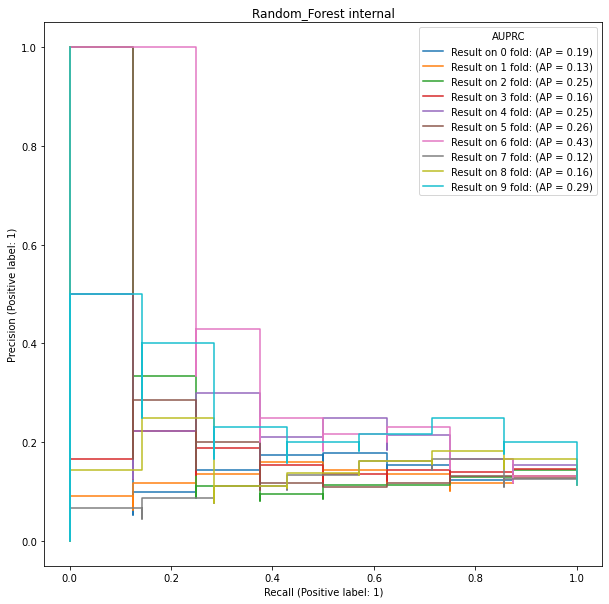

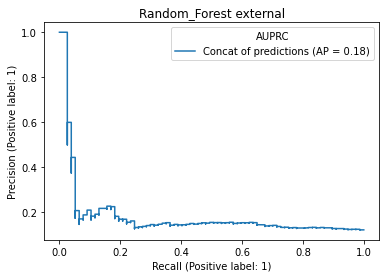

In [44]:
train_using_multivariate_on_fold(df_mrna_removed, label, list_selected_feature_mrna, 10,
                         'r_function_with_mannwhitney_boruta', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'mrna',
                         'boruta')

# Train cnv

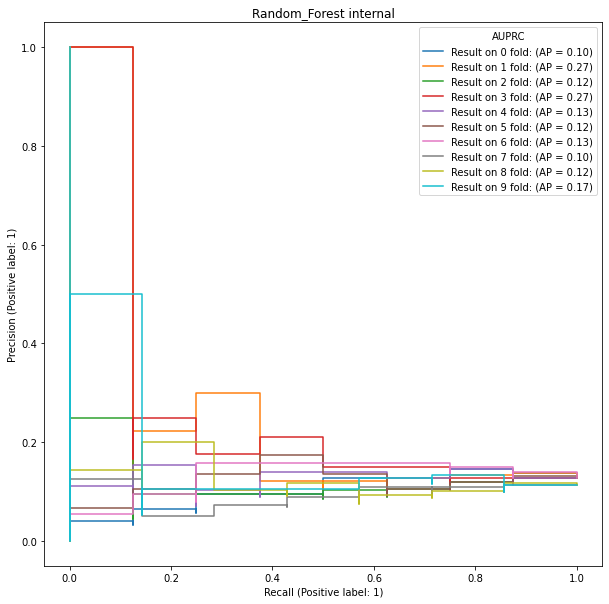

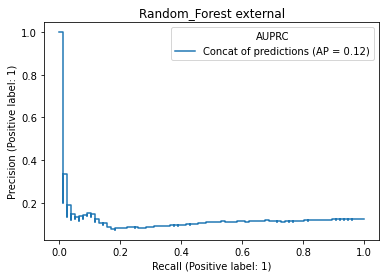

In [45]:
list_selected_feature_cnv = train_using_mann_whitney_on_fold(
    df_cnv_removed, label, 10, 'cnv', 'r_function_with_mannwhitney',
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/')

Running fold : 3it [00:07,  2.43s/it]

042
19 	 59 	 hsa-mir-31 	 0.042
20 	 66 	 hsa-mir-3194 	 0.042
21 	 65 	 hsa-mir-20b 	 0.042
22 	 64 	 hsa-mir-550a-2 	 0.042
23 	 53 	 hsa-mir-887 	 0.042
24 	 60 	 hsa-mir-592 	 0.042
25 	 34 	 hsa-mir-34b 	 0.042
26 	 54 	 hsa-mir-26b 	 0.042
27 	 9 	 hsa-mir-130a 	 0.042
28 	 17 	 hsa-mir-4254 	 0.042
29 	 16 	 hsa-mir-3936 	 0.042
30 	 15 	 hsa-mir-148a 	 0.042
31 	 20 	 hsa-mir-301a 	 0.043
32 	 7 	 hsa-mir-187 	 0.043
33 	 5 	 hsa-mir-155 	 0.043
34 	 4 	 hsa-mir-514-2 	 0.043
35 	 3 	 hsa-mir-339 	 0.043
36 	 18 	 hsa-mir-142 	 0.043
37 	 25 	 hsa-mir-1539 	 0.043
38 	 24 	 hsa-mir-16-2 	 0.043
39 	 26 	 hsa-mir-19b-2 	 0.043
40 	 28 	 hsa-mir-1277 	 0.043
41 	 21 	 hsa-mir-30c-2 	 0.043
42 	 31 	 hsa-mir-1291 	 0.043
43 	 36 	 hsa-mir-659 	 0.012
44 	 32 	 hsa-mir-29b-2 	 0.012
45 	 30 	 hsa-mir-24-1 	 0.012
46 	 6 	 hsa-mir-30b 	 0.011
47 	 14 	 hsa-mir-126 	 0.009
48 	 57 	 hsa-mir-33a 	 0.009
49 	 58 	 hsa-mir-92a-1 	 0.009
50 	 22 	 hsa-mir-454 	 0.009
51 	 56 	 hsa-mir-6

Running fold : 8it [00:19,  2.40s/it]

 max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 3 	 PTPRCAP 	 1.017
2 	 1 	 ZDHHC13 	 0.344

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 3 	 PTPRCAP 	 1.017
2 	 1 	 ZDHHC13 	 0.963
3 	 2 	 L3MBTL4 	 0.661


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 3 	 LINC00662 	 0.140
2 	 2 	 C19orf40 	 0

{0: ['DLG2',
  'C19orf40',
  'ABR',
  'LINC00662',
  'CAPN12',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
  'ZDHHC13',
 

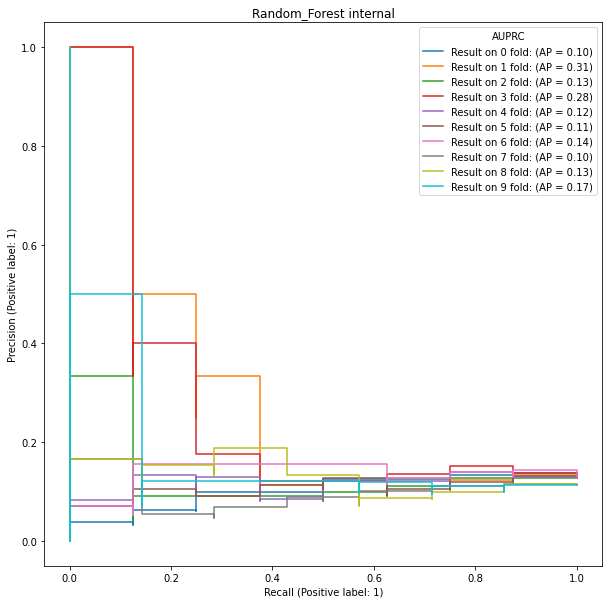

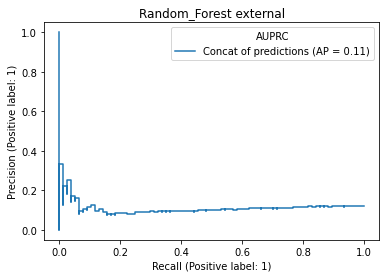

In [46]:
train_using_multivariate_on_fold(df_cnv_removed, label, list_selected_feature_cnv, 10,
                         'r_function_with_mannwhitney_mrmr', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'cnv',
                         'mrmr')

In [53]:
#fit failed
'''train_using_multivariate_on_fold(df_cnv_removed, label, list_selected_feature_cnv, 10,
                         'r_function_with_mannwhitney_boruta', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'cnv',
                         'boruta')'''

"train_using_multivariate_on_fold(df_cnv_removed, label, list_selected_feature_cnv, 10,\n                         'r_function_with_mannwhitney_boruta', \n                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',\n                         'cnv',\n                         'boruta')"

# Train whole dataset

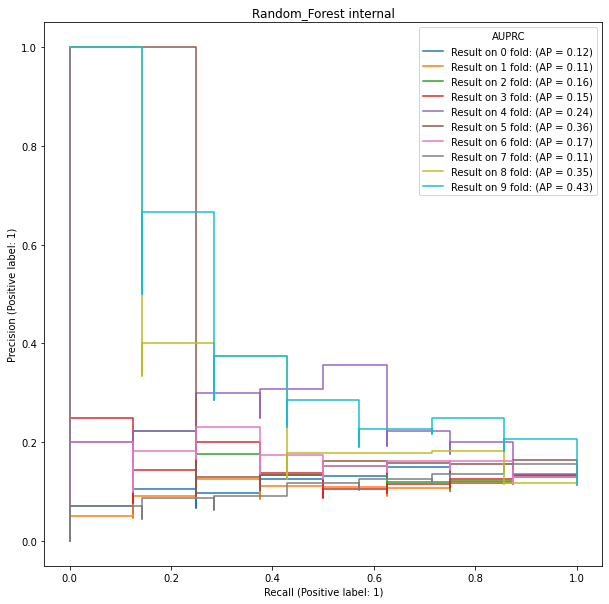

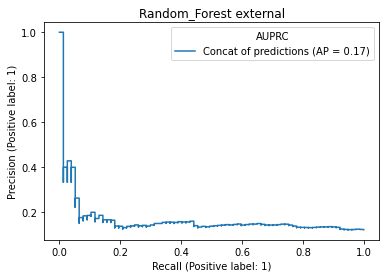

In [48]:
list_selected_feature_whole_dataset = train_using_mann_whitney_on_fold(
    df_dataset_whole_dataset_removed, label, 10, 'whole_dataset',
    'r_function_with_mannwhitney', 'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/')

In [49]:
#impiega troppo tempo
'''train_using_multivariate_on_fold(df_dataset_whole_dataset_removed, label, list_selected_feature_whole_dataset, 10,
                         'r_function_with_mannwhitney_mrmr', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'whole_dataset',
                         'mrmr')'''

"train_using_multivariate_on_fold(df_dataset_whole_dataset_removed, label, list_selected_feature_concat, 10,\n                         'r_function_with_mannwhitney_mrmr', \n                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',\n                         'whole_dataset',\n                         'mrmr')"

{0: ['TMEM156',
  'SRRM5',
  'TTC36',
  'RTP4',
  'FLJ40330',
  'PRSS45',
  'ATAD3C',
  'BCAS4',
  'PABPC1L',
  'LOC96610',
  'ITM2C',
  'p27',
  'CXCL16'],
 1: ['C6orf226',
  'LRIG1',
  'FBF1',
  'SRRM5',
  'TTC36',
  'PRSS45',
  'ATAD3C',
  'LOC648740',
  'BCAS4',
  'PABPC1L',
  'SNX15',
  'HIST1H2AE',
  'C1orf213',
  'LOC284009',
  'MARVELD3',
  'AFG3L1'],
 2: ['TMEM156',
  'FBF1',
  'SRRM5',
  'TTC36',
  'LOC100130015',
  'FLJ40330',
  'PABPC1L',
  'ANGPTL6',
  'LOC284009',
  'AFG3L1'],
 3: ['C6orf226',
  'FN3K',
  'TTC36',
  'LOC100130015',
  'FLJ40330',
  'SPR',
  'Akt_pS473',
  'ACSF2',
  'PABPC1L',
  'SNX15',
  'C3orf62',
  'SAMD10',
  'SPTBN4',
  'mTOR',
  'ANGPTL6',
  'LOC284009'],
 4: ['C6orf226',
  'C8orf77',
  'SRRM5',
  'TTC36',
  'FLJ40330',
  'LOC100287227',
  'ACSF2',
  'BCAS4',
  'PABPC1L',
  'C17orf47',
  'SNX15',
  'VEGFB',
  'FAM164C',
  'ANGPTL6',
  'LOC284009',
  'GP6'],
 5: ['TMEM156',
  'MED19',
  'hsa-mir-155',
  'SRRM5',
  'BSCL2',
  'KIF9',
  'hsa-mir-142',


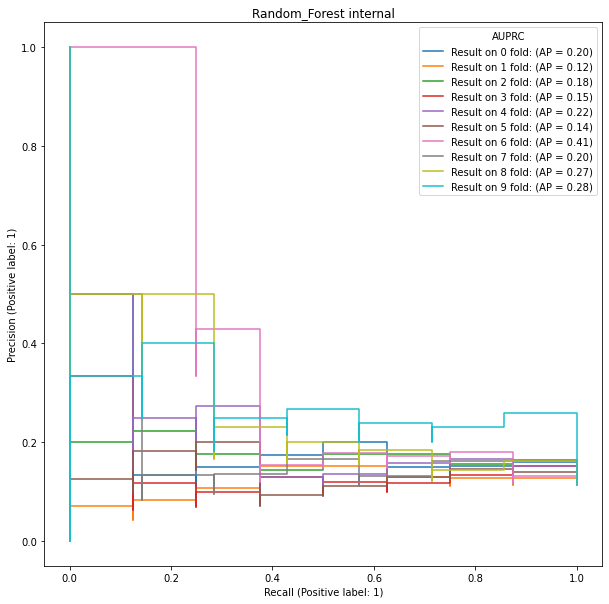

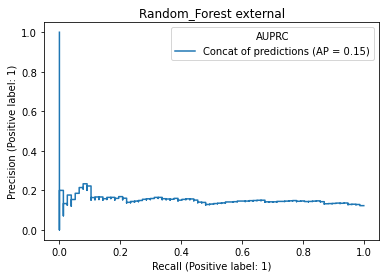

In [50]:
train_using_multivariate_on_fold(df_dataset_whole_dataset_removed, label, list_selected_feature_whole_dataset, 10,
                         'r_function_with_mannwhitney_boruta', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'whole_dataset',
                         'boruta')

# Train proteins+mirna

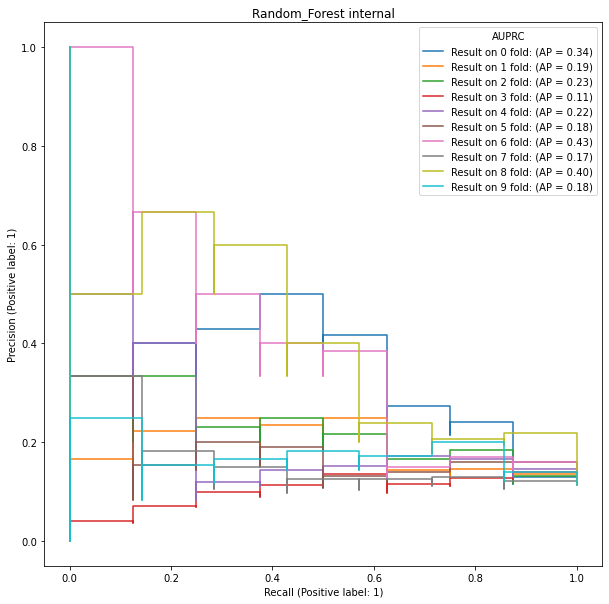

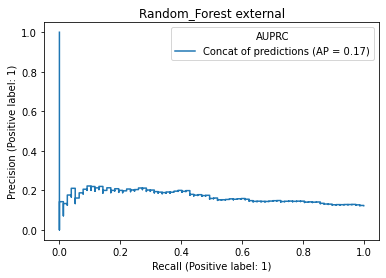

In [56]:
list_selected_feature_proteins_mirna = train_using_mann_whitney_on_fold(
    df_dataset_proteins_mirna_removed, label, 10, 'proteins_mirna',
    'r_function_with_mannwhitney', 'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/')

Running fold : 0it [00:00, ?it/s]

38, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 3 	 MACROD2 	 0.074
2 	 1 	 CCSER1 	 0.058

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 3 	 MACROD2 	 0.074
2 	 2 	 ZNF717 	 0.430
3 	 1 	 CCSER1 	 0.396


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 2 	 DLG2 	 0.163
2 	 1 	 C19orf40 	 0.140
3 	 4 	 MACROD2 	 0.106

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 2 	 DLG2 	 0.163
2 	 1 	 C19orf40 	 2.825
3 	 4 	 MACROD2 	 1.222
4 	 3 	 C5orf17 	 0.982


 *** This program and the respective 

Running fold : 1it [00:09,  9.15s/it]

49 	 hsa-mir-19a 	 0.042
19 	 65 	 hsa-mir-181d 	 0.042
20 	 58 	 Shc_pY317 	 0.042
21 	 63 	 hsa-let-7g 	 0.043
22 	 66 	 Fibronectin 	 0.043
23 	 61 	 hsa-mir-1539 	 0.043
24 	 60 	 hsa-mir-30e 	 0.043
25 	 64 	 hsa-mir-142 	 0.043
26 	 57 	 p27 	 0.043
27 	 67 	 hsa-mir-659 	 0.043
28 	 54 	 hsa-mir-3913-2 	 0.043
29 	 53 	 hsa-mir-513c 	 0.043
30 	 55 	 Annexin_VII 	 0.043
31 	 1 	 hsa-mir-29b-2 	 0.043
32 	 2 	 hsa-mir-3617 	 0.043
33 	 10 	 hsa-mir-508 	 0.043
34 	 16 	 hsa-mir-519b 	 0.043
35 	 15 	 hsa-mir-500a 	 0.043
36 	 12 	 hsa-mir-16-2 	 0.043
37 	 19 	 mTOR 	 0.043
38 	 7 	 hsa-mir-548q 	 0.043
39 	 5 	 PI3K-p110-alpha 	 0.043
40 	 3 	 hsa-mir-19b-2 	 0.043
41 	 17 	 hsa-mir-155 	 0.043
42 	 25 	 hsa-mir-130a 	 0.043
43 	 27 	 hsa-mir-339 	 0.043
44 	 33 	 hsa-mir-3942 	 0.043
45 	 31 	 PREX1 	 0.043
46 	 21 	 hsa-mir-148a 	 0.043
47 	 23 	 B-Raf_pS445 	 0.043
48 	 45 	 hsa-mir-653 	 0.012
49 	 43 	 hsa-mir-1252 	 0.012
50 	 68 	 hsa-mir-616 	 0.011
51 	 24 	 hsa-mir-660

Running fold : 2it [00:21, 11.00s/it]

 30 	 hsa-mir-320b-2 	 0.000
70 	 36 	 hsa-mir-708 	 0.000
71 	 37 	 hsa-mir-342 	 0.000
72 	 32 	 PREX1 	 0.000
73 	 38 	 INPP4B 	 0.000
74 	 26 	 hsa-mir-660 	 0.000
75 	 40 	 hsa-mir-3936 	 0.000
76 	 25 	 hsa-mir-148a 	 0.000
77 	 45 	 hsa-mir-33a 	 0.000
78 	 29 	 hsa-mir-339 	 0.000
79 	 27 	 hsa-mir-130a 	 0.000
80 	 28 	 DJ-1 	 0.000
81 	 39 	 hsa-mir-30c-2 	 0.000
82 	 88 	 hsa-mir-140 	 0.000
83 	 86 	 hsa-mir-664 	 0.000
84 	 22 	 mTOR 	 0.000
85 	 83 	 hsa-mir-514-2 	 0.000
86 	 6 	 hsa-mir-320c-1 	 0.000
87 	 69 	 hsa-mir-30e 	 0.000
88 	 41 	 hsa-mir-28 	 0.000

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 62 	 hsa-mir-592 	 0.019
2 	 49 	 hsa-mir-3154 	 0.154
3 	 65 	 hsa-mir-3180-3 	 0.125
4 	 89 	 hsa-mir-1234 	 0.097
5 	 70 	 hsa-mir-623 	 0.071
6 	 60 	 hsa-mir-4254 	 0.072
7 	 57 	 hsa-mir-26b 	 0.041
8 	 61 	 Raptor 	 0.041
9 	 58 	 A-Raf 	 0.041
10 	 59 	 hsa-mir-20a 	 0.041
11 	 56 	 hsa-mir-101-2 	 0.042
12 	 63 	 hsa-mir-223 	 0.042
13 	 48 	 hsa-mir-1

Running fold : 3it [00:40, 14.56s/it]

epsilon 	 0.043
47 	 30 	 hsa-mir-186 	 0.043
48 	 7 	 PRAS40_pT246 	 0.043
49 	 11 	 hsa-mir-320a 	 0.043
50 	 28 	 hsa-mir-3165 	 0.043
51 	 61 	 hsa-mir-1277 	 0.043
52 	 51 	 hsa-mir-342 	 0.043
53 	 53 	 hsa-mir-30c-2 	 0.043
54 	 46 	 S6_pS235_S236 	 0.043
55 	 49 	 hsa-mir-3942 	 0.043
56 	 54 	 hsa-mir-3936 	 0.043
57 	 57 	 hsa-mir-887 	 0.043
58 	 31 	 mTOR 	 0.043
59 	 38 	 hsa-mir-660 	 0.043
60 	 41 	 hsa-mir-339 	 0.043
61 	 78 	 hsa-mir-4254 	 0.030
62 	 65 	 hsa-mir-1252 	 0.014
63 	 109 	 hsa-mir-659 	 0.013
64 	 50 	 hsa-mir-129-2 	 0.011
65 	 42 	 hsa-mir-320b-2 	 0.011
66 	 33 	 hsa-mir-29c 	 0.012
67 	 29 	 hsa-mir-155 	 0.012
68 	 59 	 hsa-mir-33a 	 0.012
69 	 19 	 hsa-mir-642a 	 0.012
70 	 17 	 hsa-mir-29a 	 0.012
71 	 12 	 hsa-mir-320c-1 	 0.012
72 	 91 	 hsa-mir-181c 	 0.012
73 	 21 	 Bcl-2 	 0.012
74 	 43 	 XRCC1 	 0.013
75 	 44 	 PREX1 	 0.013
76 	 100 	 Akt_pT308 	 0.013
77 	 63 	 hsa-mir-15a 	 0.013
78 	 23 	 hsa-mir-362 	 0.013
79 	 82 	 hsa-mir-3613 	 0.0

Running fold : 4it [01:00, 16.72s/it]

-17 	 0.000
100 	 47 	 GSK3_pS9 	 0.000


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 33 	 hsa-mir-92a-1 	 0.019
2 	 21 	 hsa-mir-20b 	 0.019
3 	 50 	 hsa-mir-20a 	 0.019
4 	 61 	 hsa-mir-1322 	 0.000
5 	 80 	 hsa-mir-1234 	 0.000
6 	 15 	 hsa-mir-567 	 0.000
7 	 52 	 hsa-mir-4254 	 0.000
8 	 70 	 hsa-mir-3178 	 0.000
9 	 34 	 hsa-mir-4279 	 0.000
10 	 67 	 hsa-mir-623 	 0.000
11 	 53 	 hsa-mir-489 	 0.000
12 	 49 	 hsa-mir-26b 	 0.000
13 	 54 	 Raptor 	 0.000
14 	 57 	 hsa-mir-3913-2 	 0.000
15 	 45 	 hsa-mir-95 	 0.000


Running fold : 5it [01:09, 14.01s/it]

3
40 	 11 	 hsa-mir-627 	 0.043
41 	 4 	 hsa-mir-19b-2 	 0.043
42 	 6 	 hsa-mir-320a 	 0.043
43 	 19 	 hsa-mir-186 	 0.043
44 	 5 	 PRAS40_pT246 	 0.043
45 	 18 	 hsa-mir-1293 	 0.043
46 	 20 	 mTOR 	 0.043
47 	 35 	 hsa-mir-3162 	 0.043
48 	 32 	 hsa-mir-30c-2 	 0.043
49 	 36 	 hsa-mir-496 	 0.043
50 	 38 	 hsa-mir-1277 	 0.043
51 	 31 	 hsa-mir-342 	 0.043
52 	 22 	 hsa-mir-148a 	 0.043
53 	 26 	 hsa-mir-339 	 0.043
54 	 28 	 XRCC1 	 0.043
55 	 24 	 hsa-mir-130a 	 0.043
56 	 2 	 hsa-mir-29b-2 	 0.015
57 	 41 	 hsa-mir-1252 	 0.013
58 	 27 	 hsa-mir-320b-2 	 0.010
59 	 37 	 hsa-mir-33a 	 0.011
60 	 12 	 hsa-mir-16-2 	 0.011
61 	 39 	 hsa-mir-556 	 0.011
62 	 16 	 p38_pT180_Y182 	 0.011
63 	 7 	 hsa-mir-320c-1 	 0.011
64 	 14 	 hsa-mir-362 	 0.011
65 	 57 	 hsa-mir-3913-2 	 0.011
66 	 46 	 hsa-mir-653 	 0.012
67 	 13 	 hsa-mir-30b 	 0.008
68 	 29 	 hsa-mir-550a-2 	 0.007
69 	 25 	 DJ-1 	 0.007
70 	 69 	 hsa-mir-643 	 0.007
71 	 30 	 hsa-mir-3170 	 0.007
72 	 71 	 hsa-mir-454 	 0.007
73

Running fold : 6it [01:23, 13.91s/it]

 0.000
79 	 45 	 hsa-mir-28 	 0.000
80 	 38 	 hsa-mir-3170 	 0.000
81 	 47 	 hsa-mir-4279 	 0.000
82 	 32 	 hsa-mir-339 	 0.000
83 	 2 	 hsa-mir-29b-2 	 0.000
84 	 31 	 hsa-mir-141 	 0.000
85 	 39 	 hsa-mir-3942 	 0.000
86 	 33 	 hsa-mir-320b-2 	 0.000
87 	 35 	 hsa-mir-550a-2 	 0.000
88 	 54 	 hsa-mir-1252 	 0.000
89 	 3 	 hsa-mir-3617 	 0.000
90 	 48 	 hsa-mir-507 	 0.000
91 	 28 	 hsa-mir-513a-2 	 0.000
92 	 9 	 hsa-mir-561 	 0.000
93 	 90 	 eIF4E 	 0.000
94 	 19 	 hsa-mir-30b 	 0.000
95 	 22 	 p38_pT180_Y182 	 0.000
96 	 24 	 hsa-mir-155 	 0.000

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 63 	 hsa-mir-20a 	 0.019
2 	 46 	 hsa-mir-92a-1 	 0.995
3 	 86 	 hsa-mir-185 	 0.995
4 	 42 	 hsa-mir-17 	 0.995
5 	 26 	 hsa-mir-20b 	 0.995
6 	 8 	 hsa-mir-30c-1 	 0.993
7 	 49 	 hsa-mir-657 	 0.150
8 	 71 	 hsa-mir-3180-3 	 0.142
9 	 34 	 hsa-mir-548s 	 0.078
10 	 77 	 hsa-mir-623 	 0.078
11 	 81 	 hsa-mir-3178 	 0.078
12 	 67 	 hsa-mir-592 	 0.042
13 	 68 	 hsa-mir-513c 	 0.042
14 	

Running fold : 7it [01:32, 12.50s/it]

007
66 	 13 	 hsa-mir-30b 	 0.005
67 	 7 	 hsa-let-7f-1 	 0.000
68 	 11 	 hsa-mir-16-2 	 0.000
69 	 55 	 hsa-mir-489 	 0.000
70 	 45 	 hsa-mir-15a 	 0.000
71 	 67 	 hsa-mir-191 	 0.000
72 	 48 	 hsa-mir-1291 	 0.000
73 	 3 	 hsa-mir-19b-2 	 0.000
74 	 59 	 hsa-mir-3913-2 	 0.000
75 	 1 	 hsa-mir-29b-2 	 0.000


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 67 	 hsa-mir-20a 	 0.019
2 	 29 	 hsa-mir-20b 	 0.019
3 	 99 	 hsa-mir-1234 	 0.000
4 	 51 	 hsa-mir-4279 	 0.000
5 	 83 	 hsa-mir-3178 	 0.000
6 	 69 	 hsa-mir-4254 	 0.

Running fold : 8it [01:48, 13.50s/it]

hsa-mir-101-2 	 0.042
13 	 73 	 hsa-mir-513c 	 0.042
14 	 64 	 hsa-mir-93 	 0.042
15 	 56 	 hsa-mir-556 	 0.043
16 	 57 	 hsa-mir-3194 	 0.043
17 	 53 	 hsa-mir-33a 	 0.043
18 	 54 	 hsa-mir-31 	 0.043
19 	 55 	 hsa-mir-1277 	 0.043
20 	 59 	 Ku80 	 0.043
21 	 60 	 hsa-mir-1291 	 0.043
22 	 75 	 Jak2 	 0.043
23 	 93 	 hsa-mir-514-2 	 0.043
24 	 94 	 TAZ 	 0.043
25 	 90 	 hsa-mir-3126 	 0.043
26 	 91 	 hsa-mir-659 	 0.043
27 	 92 	 hsa-mir-21 	 0.043
28 	 87 	 hsa-mir-374a 	 0.043
29 	 95 	 hsa-mir-664 	 0.043
30 	 97 	 EGFR_pY1173 	 0.043
31 	 89 	 hsa-mir-181d 	 0.043
32 	 80 	 hsa-let-7g 	 0.043
33 	 78 	 hsa-mir-30e 	 0.043
34 	 79 	 hsa-mir-623 	 0.043
35 	 76 	 p27 	 0.043
36 	 82 	 hsa-mir-142 	 0.043
37 	 85 	 FASN 	 0.043
38 	 52 	 hsa-mir-3162 	 0.043
39 	 19 	 hsa-mir-24-1 	 0.043
40 	 20 	 Bcl-2 	 0.043
41 	 16 	 hsa-mir-627 	 0.043
42 	 17 	 hsa-mir-576 	 0.043
43 	 18 	 hsa-mir-16-2 	 0.043
44 	 14 	 hsa-mir-519c 	 0.043
45 	 13 	 hsa-mir-508 	 0.043
46 	 23 	 hsa-mir-500a

Running fold : 9it [01:57, 12.03s/it]

5 	 hsa-mir-1277 	 0.000
36 	 15 	 hsa-mir-155 	 0.000
37 	 13 	 hsa-mir-500a 	 0.000
38 	 18 	 hsa-mir-20b 	 0.000
39 	 17 	 mTOR 	 0.000
40 	 16 	 hsa-mir-186 	 0.000
41 	 20 	 hsa-mir-513a-2 	 0.000
42 	 14 	 hsa-mir-550a-1 	 0.000
43 	 22 	 hsa-mir-320b-2 	 0.000
44 	 12 	 hsa-mir-362 	 0.000
45 	 11 	 hsa-mir-16-2 	 0.000
46 	 10 	 4E-BP1_pS65 	 0.000
47 	 19 	 hsa-mir-148a 	 0.000
48 	 9 	 hsa-mir-34b 	 0.000
49 	 21 	 hsa-mir-339 	 0.000
50 	 29 	 hsa-mir-92a-1 	 0.000
51 	 27 	 hsa-mir-3942 	 0.000
52 	 32 	 hsa-mir-3162 	 0.000
53 	 2 	 hsa-mir-3617 	 0.000
54 	 30 	 hsa-mir-887 	 0.000
55 	 33 	 hsa-mir-33a 	 0.000
56 	 28 	 hsa-mir-129-2 	 0.000
57 	 23 	 hsa-mir-548s 	 0.000
58 	 26 	 hsa-mir-550a-2 	 0.000
59 	 25 	 PREX1 	 0.000
60 	 24 	 XRCC1 	 0.000

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 47 	 hsa-mir-592 	 0.019
2 	 53 	 hsa-mir-1322 	 0.267
3 	 61 	 hsa-mir-1234 	 0.100
4 	 44 	 hsa-mir-4254 	 0.065
5 	 56 	 hsa-mir-3178 	 0.068
6 	 54 	 hsa-mir-623 	 

{0: ['hsa-mir-592',
  'hsa-mir-657',
  'hsa-mir-1234',
  'hsa-mir-623',
  'hsa-mir-548s',
  'hsa-mir-4254',
  'hsa-mir-4279',
  'hsa-mir-1291',
  'hsa-mir-662',
  'hsa-mir-20a',
  'hsa-mir-26b',
  'hsa-mir-101-2',
  'hsa-mir-514-2',
  'Raptor',
  'hsa-mir-556',
  'hsa-mir-1277',
  'hsa-mir-33a',
  'hsa-mir-19a',
  'hsa-mir-181d',
  'Shc_pY317',
  'hsa-let-7g',
  'Fibronectin',
  'hsa-mir-1539',
  'hsa-mir-30e',
  'hsa-mir-142',
  'p27',
  'hsa-mir-659',
  'hsa-mir-3913-2',
  'hsa-mir-513c',
  'Annexin_VII',
  'hsa-mir-29b-2',
  'hsa-mir-3617',
  'hsa-mir-508',
  'hsa-mir-519b',
  'hsa-mir-500a',
  'hsa-mir-16-2',
  'mTOR',
  'hsa-mir-548q',
  'PI3K-p110-alpha',
  'hsa-mir-19b-2',
  'hsa-mir-155',
  'hsa-mir-130a',
  'hsa-mir-339',
  'hsa-mir-3942',
  'PREX1',
  'hsa-mir-148a',
  'B-Raf_pS445',
  'hsa-mir-653',
  'hsa-mir-1252',
  'hsa-mir-616',
  'hsa-mir-660',
  'Bcl-2',
  'hsa-let-7f-1',
  'hsa-mir-28',
  'hsa-mir-181c',
  'hsa-mir-362',
  'hsa-mir-550a-2',
  'hsa-mir-34b',
  'hsa-mi

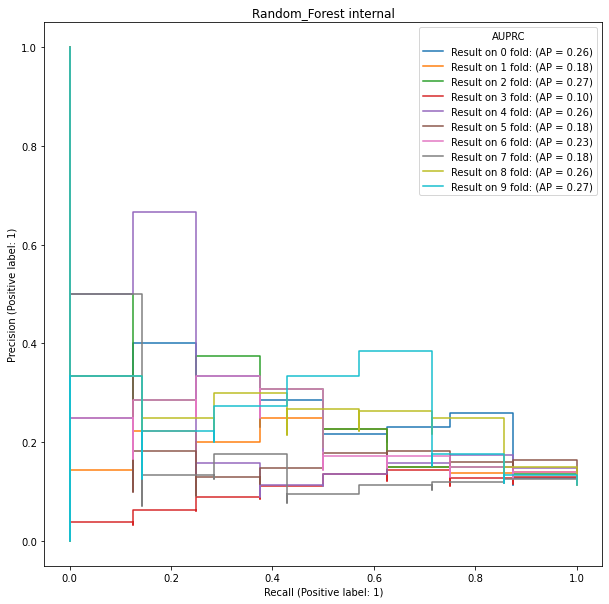

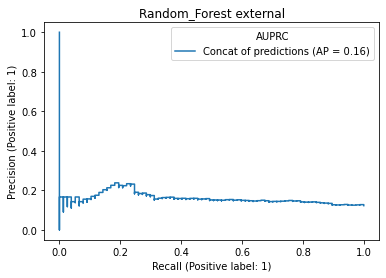

In [57]:
train_using_multivariate_on_fold(df_dataset_proteins_mirna_removed, label, list_selected_feature_proteins_mirna, 10,
                         'r_function_with_mannwhitney_mrmr', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'proteins_mirna',
                         'mrmr')

{0: ['PRAS40_pT246',
  'mTOR',
  'hsa-mir-130a',
  'hsa-mir-653',
  'Annexin_VII',
  'p27',
  'hsa-mir-142'],
 1: ['PRAS40_pT246',
  '4E-BP1_pS65',
  'mTOR',
  'hsa-mir-148a',
  'XRCC1',
  'PREX1',
  'mTOR_pS2448',
  'p27',
  'hsa-let-7g',
  'hsa-mir-142'],
 2: ['hsa-mir-29b-2', 'PRAS40_pT246', 'hsa-mir-29c', 'p27', 'MIG-6'],
 3: ['hsa-mir-29b-2',
  'PRAS40_pT246',
  'mTOR',
  'hsa-mir-130a',
  'XRCC1',
  'Ku80',
  'Akt_pS473',
  'p27',
  'hsa-let-7g'],
 4: ['hsa-mir-29b-2',
  'XRCC1',
  'Jak2',
  'p27',
  'Shc_pY317',
  'hsa-let-7g',
  'eIF4E'],
 5: ['PRAS40_pT246',
  'hsa-mir-155',
  'GSK3_pS9',
  'p27',
  'hsa-let-7g',
  'hsa-mir-142'],
 6: ['mTOR', 'hsa-mir-20b', 'p27'],
 7: ['PRAS40_pT246',
  'mTOR',
  'B-Raf_pS445',
  'XRCC1',
  'PREX1',
  'p27',
  'hsa-let-7g'],
 8: ['hsa-mir-155', 'mTOR', 'PREX1', 'p27', 'Shc_pY317'],
 9: ['hsa-mir-19b-2', 'hsa-mir-362', 'mTOR', 'Shc_pY317', 'hsa-let-7g']}

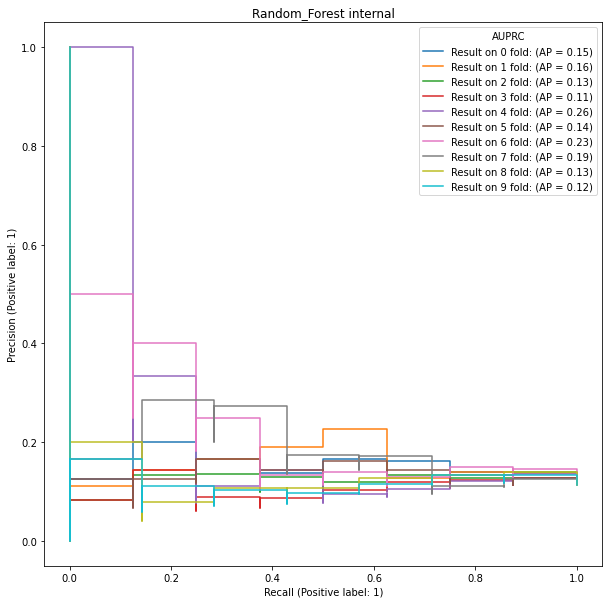

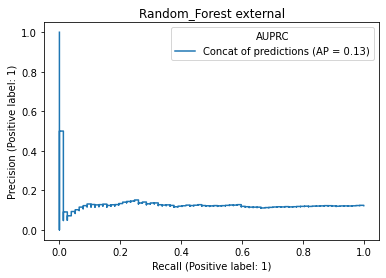

In [58]:
train_using_multivariate_on_fold(df_dataset_proteins_mirna_removed, label, list_selected_feature_proteins_mirna, 10,
                         'r_function_with_mannwhitney_boruta', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'proteins_mirna',
                         'boruta')

# Train proteins+mirna+mrna

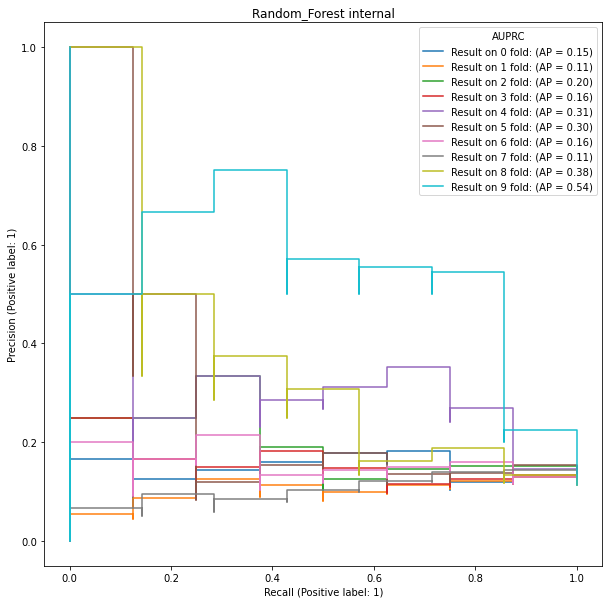

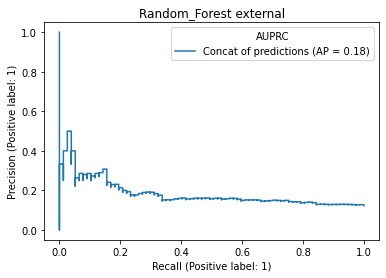

In [59]:
list_selected_feature_proteins_mirna_mrna = train_using_mann_whitney_on_fold(
    df_dataset_proteins_mirna_mrna_removed, label, 10, 'proteins_mirna_mrna',
    'r_function_with_mannwhitney', 'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/')

In [ ]:
#too much time
'''train_using_multivariate_on_fold(df_dataset_proteins_mirna_mrna_removed, label, list_selected_feature_proteins_mirna_mrna, 10,
                         'r_function_with_mannwhitney_mrmr', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'proteins_mirna_mrna',
                         'mrmr')'''

{0: ['FLJ40330',
  'C6orf226',
  'LRRC48',
  'p27',
  'RTP4',
  'TTC36',
  'BCAS4',
  'LOC284009',
  'TMEM156',
  'TDRD5',
  'SNX15',
  'LOC96610',
  'CASP9',
  'SRRM5',
  'VEGFB',
  'PRSS45',
  'ITM2C',
  'PABPC1L'],
 1: ['LOC100130015',
  'FLJ40330',
  'C6orf226',
  'NCRNA00204B',
  'HIST1H2AE',
  'AFG3L1',
  'C1orf213',
  'MARVELD3',
  'FBF1',
  'TTC36',
  'BCAS4',
  'PIM2',
  'PARD6A',
  'LOC284009',
  'ACSF2',
  'SNX15',
  'SRRM5',
  'TTLL3',
  'PRSS45',
  'LOC648740',
  'ATAD3C'],
 2: ['LOC100130015',
  'KLHDC7B',
  'FLJ40330',
  'C6orf226',
  'AFG3L1',
  'MIG-6',
  'SPTBN4',
  'FBF1',
  'TTC36',
  'NDUFS8',
  'ANGPTL6',
  'SNX15',
  'SRRM5',
  'NCRNA00173',
  'GRIN2C',
  'LOC648740',
  'SAMD10',
  'GOLGA8B',
  'PABPC1L',
  'DBNDD2',
  'GNAO1',
  'C1orf93'],
 3: ['LOC100130015',
  'hsa-mir-130a',
  'FLJ40330',
  'C6orf226',
  'LOC284276',
  'SPTBN4',
  'BCAS4',
  'EPS8L2',
  'LOC284009',
  'ACSF2',
  'ANGPTL6',
  'SNX15',
  'SRRM5',
  'FN3K',
  'PABPC1L',
  'C3orf62',
  'HLA-DPB2

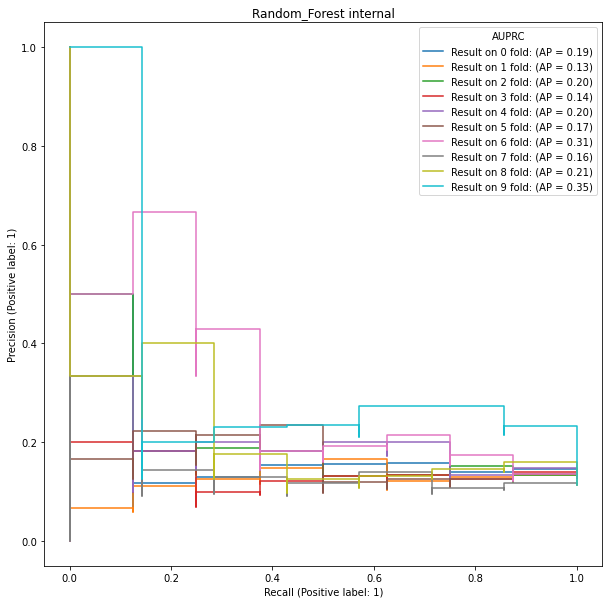

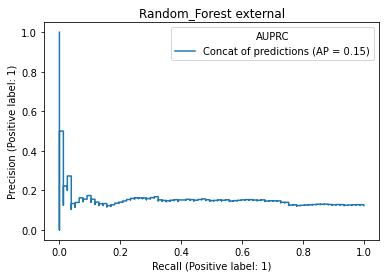

In [60]:
train_using_multivariate_on_fold(df_dataset_proteins_mirna_mrna_removed, label, list_selected_feature_proteins_mirna_mrna, 10,
                         'r_function_with_mannwhitney_boruta', 
                         'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_on_fold/',
                         'proteins_mirna_mrna',
                         'boruta')

# Feature selection on whole dataset before train with: 1) mannwthineyu, 2) mannwthineyu + boruta and mannwthineyu + mrmr 

# Prepare data mannwhitney

In [51]:
proteins_selected_features = mann_whitney_features_selection(df_proteins_removed, label, 0.05)
proteins_mannwhitney = df_proteins_removed[proteins_selected_features]

In [52]:
proteins_mannwhitney

,PRAS40_pT246,GSK3_pS9,Raptor,mTOR,FASN,A-Raf,p27,Jak2,PREX1,Shc_pY317,p38_pT180_Y182,XRCC1,Akt_pS473,Ku80,Bcl-2
0,0.617066,0.686583,0.529149,0.492546,0.535370,0.597189,0.218901,0.661667,0.287046,0.505836,0.562600,0.535748,0.219820,0.521106,0.310967
1,0.495525,0.672550,0.585857,0.719286,0.583959,0.692356,0.442895,0.594790,0.416917,0.534023,0.667240,0.469614,0.132222,0.667190,0.552296
2,0.477525,0.697664,0.686111,0.726308,0.565189,0.677520,0.288495,0.610465,0.457793,0.450023,0.571665,0.760971,0.133543,0.702360,0.411262
3,0.619577,0.743051,0.473294,0.696904,0.457468,0.701265,0.416031,0.638760,0.406906,0.519531,0.642789,0.820749,0.450831,0.883264,0.445253
4,0.436008,0.410635,0.529218,0.732141,0.436260,0.668388,0.193335,0.608172,0.466793,0.566631,0.206878,0.809805,0.085647,0.829856,0.519383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,0.598971,0.624226,0.467071,0.292064,0.308092,0.131184,0.489697,0.564028,0.328515,0.597040,0.303551,0.218445,0.264756,0.000000,0.221229
623,0.358247,0.725609,0.667221,0.786068,0.291593,0.660413,0.433030,0.682370,0.391842,0.588110,0.765590,0.759158,0.183027,0.867785,0.578258
624,0.425565,0.756008,0.455318,0.653618,0.610368,0.608169,0.274580,0.535525,0.471010,0.499953,0.532947,0.663697,0.178079,0.784729,0.475459
625,0.453955,0.804405,0.633603,0.718558,0.309929,0.706199,0.200432,0.466529,0.338164,0.615754,0.816809,0.752783,0.318803,0.699438,0.535056


In [53]:
cnv_selected_features = mann_whitney_features_selection(df_cnv_removed, label, 0.05)
cnv_mannwhitney = df_cnv_removed[cnv_selected_features]

In [54]:
mirna_selected_features = mann_whitney_features_selection(df_mirna_removed, label, 0.05)
mirna_mannwhitney = df_mirna_removed[mirna_selected_features]

In [55]:
mrna_selected_features = mann_whitney_features_selection(df_mrna_removed, label, 0.05)
mrna_mannwhitney = df_mrna_removed[mrna_selected_features]

In [101]:
whole_dataset_selected_features = mann_whitney_features_selection(df_dataset_whole_dataset_removed, label, 0.05)
whole_mannwhitney = df_dataset_whole_dataset_removed[whole_dataset_selected_features]

In [97]:
dataset_proteins_mirna_selected_features = mann_whitney_features_selection(
    df_dataset_proteins_mirna_removed,label, 0.05)


dataset_proteins_mirna_mannwhitney = df_dataset_proteins_mirna_removed[dataset_proteins_mirna_selected_features]

In [98]:
dataset_proteins_mirna_mrna_selected_features = mann_whitney_features_selection(
    df_dataset_proteins_mirna_mrna_removed,label, 0.05)

dataset_proteins_mirna_mrna_mannwhitney = df_dataset_proteins_mirna_mrna_removed[dataset_proteins_mirna_mrna_selected_features]

# Prepare data Boruta

In [59]:
proteins_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(proteins_mannwhitney, label, 5)

In [60]:
proteins_mannwhitney_boruta = proteins_mannwhitney[proteins_selected_features_boruta]

In [61]:
cnv_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(cnv_mannwhitney, label, 5)

In [62]:
cnv_mannwhitney_boruta = cnv_mannwhitney[cnv_selected_features_boruta]

In [63]:
mirna_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(mirna_mannwhitney, label, 5)

In [64]:
mirna_mannwhitney_boruta = mirna_mannwhitney[mirna_selected_features_boruta]

In [65]:
mrna_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(mrna_mannwhitney, label, 5)

In [66]:
mrna_mannwhitney_boruta = mrna_mannwhitney[mrna_selected_features_boruta]

In [102]:
whole_dataset_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(whole_mannwhitney, label, 5)

In [103]:
whole_dataset_mannwhitney_boruta = whole_mannwhitney[whole_dataset_selected_features_boruta]

In [104]:
dataset_proteins_mirna_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(dataset_proteins_mirna_mannwhitney, label, 5)

In [105]:
proteins_mirna_boruta = dataset_proteins_mirna_mannwhitney[dataset_proteins_mirna_selected_features_boruta]

In [106]:
dataset_proteins_mirna_mrna_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(dataset_proteins_mirna_mrna_mannwhitney, label, 5)

In [107]:
proteins_mirna_mrna_boruta = dataset_proteins_mirna_mrna_mannwhitney[dataset_proteins_mirna_mrna_selected_features_boruta]

# Prepare data mrmr

In [71]:
proteins_selected_features_mrmr = execute_mrmr(proteins_mannwhitney, 100)

In [72]:
proteins_mannwhitney_mrmr = proteins_mannwhitney[proteins_selected_features_mrmr]

In [73]:
cnv_selected_features_mrmr = execute_mrmr(cnv_mannwhitney, 100)

In [74]:
cnv_mannwhitney_mrmr = cnv_mannwhitney[cnv_selected_features_mrmr]

In [75]:
mirna_selected_features_mrmr = execute_mrmr(mirna_mannwhitney, 100)

38, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 3 	 MACROD2 	 0.074
2 	 1 	 CCSER1 	 0.058

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 3 	 MACROD2 	 0.074
2 	 2 	 ZNF717 	 0.430
3 	 1 	 CCSER1 	 0.396


 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 2 	 DLG2 	 0.163
2 	 1 	 C19orf40 	 0.140
3 	 4 	 MACROD2 	 0.106

*** mRMR features *** 
Order 	 Fea 	 Name 	 Score
1 	 2 	 DLG2 	 0.163
2 	 1 	 C19orf40 	 2.825
3 	 4 	 MACROD2 	 1.222
4 	 3 	 C5orf17 	 0.982


 *** This program and the respective 

In [76]:
mirna_mannwhitney_mrmr = mirna_mannwhitney[mirna_selected_features_mrmr]

In [77]:
#mrna_selected_features_mrmr = execute_mrmr(mrna_mannwhitney, 100)

In [78]:
#mrna_mannwhitney_mrmr = mrna_mannwhitney[mrna_selected_features_mrmr]

In [79]:
#whole_dataset_selected_features_mrmr = execute_mrmr(whole_mannwhitney, 100)

In [80]:
#whole_mannwhitney_mrmr = whole_mannwhitney[whole_dataset_selected_features_mrmr]

In [108]:
dataset_proteins_mirna_selected_features_mrmr = execute_mrmr(dataset_proteins_mirna_mannwhitney, 100)



 *** This program and the respective minimum Redundancy Maximum Relevance (mRMR) 
     algorithm were developed by Hanchuan Peng <hanchuan.peng@gmail.com>for
     the paper 
     "Feature selection based on mutual information: criteria of 
      max-dependency, max-relevance, and min-redundancy,"
      Hanchuan Peng, Fuhui Long, and Chris Ding, 
      IEEE Transactions on Pattern Analysis and Machine Intelligence,
      Vol. 27, No. 8, pp.1226-1238, 2005.


*** MaxRel features ***
Order 	 Fea 	 Name 	 Score
1 	 67 	 hsa-mir-592 	 0.017
2 	 91 	 hsa-mir-1234 	 0.000
3 	 32 	 hsa-mir-548s 	 0.000
4 	 79 	 hsa-mir-3178 	 0.000
5 	 75 	 hsa-mir-623 	 0.000
6 	 64 	 hsa-mir-4254 	 0.000
7 	 46 	 hsa-mir-4279 	 0.000
8 	 66 	 Raptor 	 0.000
9 	 5 	 PRAS40_pT246 	 0.000
10 	 6 	 hsa-mir-320a 	 0.000
11 	 65 	 hsa-mir-489 	 0.000
12 	 62 	 hsa-mir-20a 	 0.000
13 	 60 	 Akt_pS473 	 0.000
14 	 68 	 hsa-mir-513c 	 0.000
15 	 69 	 hsa-mir-3913-2 	 0.000
16 	 63 	 hsa-mir-19a 	 0.000
17 	 71 	 p2

In [109]:
proteins_mirna_mrmr = dataset_proteins_mirna_mannwhitney[dataset_proteins_mirna_selected_features_mrmr]

In [82]:
#dataset_proteins_mirna_mrna_selected_features_mrmr = execute_mrmr(dataset_proteins_mirna_mrna_mannwhitney, 100)

In [ ]:
#mrna, whole dataset and proteins+mirna+mrna with mrmr too much time

# Training function on whole dataset

In [110]:
def train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(X, label, num_external_fold,
                                          type_dataset, tecnique_feature_selection,
                                          path):
    
    """
    X : data using number of features of intrinsic dimensionality and appliying umap features extraction.
    """
    
    _, ax = plt.subplots(figsize=(10, 10))
    average_precision_scores =[]
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {}   
    iterator = 1
    
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_fold, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_fold)[:, 1]
        
        avg_precision_score = average_precision_score(y_test_fold, y_score)
        average_precision_scores.append(avg_precision_score)
        
        #concatenation of result for external AUPRC
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
               
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score, ax=ax,name=f'Result on {iterator} fold:')

        plt.title('Random_Forest internal')
        ax.legend(title='AUPRC')
        
        plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_AUPRC_Internal.pdf')
        
        iterator = iterator + 1
        
    internal_average_precision_score = np.mean(average_precision_scores)
    
    external_average_precision_score = average_precision_score(y_test_fold_concatenated, y_score_concatenated)

    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated,name='Concat of predictions')
    plt.title('Random_Forest external')
    plt.legend(title='AUPRC')
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    
    plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_External.pdf')
    
    with open('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    
    return '{0:.4f}'.format(internal_average_precision_score), '{0:.4f}'.format(external_average_precision_score), clf.best_estimator_

# Proteins only with mannwhitney feature selection on whole dataset

mkdir: impossibile creare la directory "Result/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset": File già esistente


('0.2498',
 '0.1884',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=2, n_estimators=51))

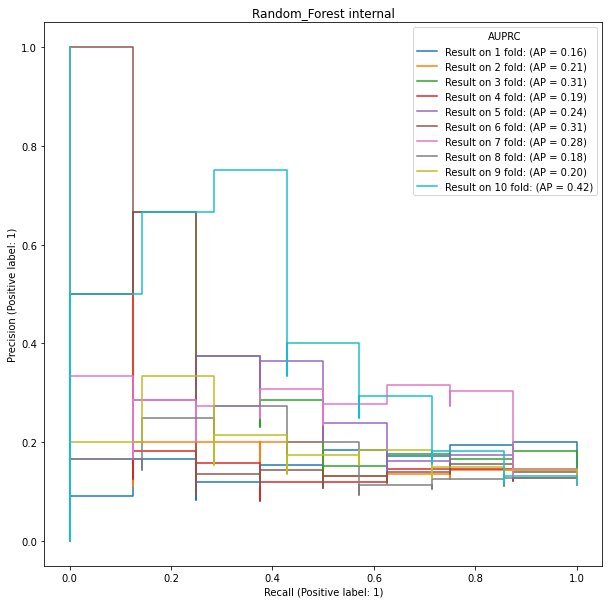

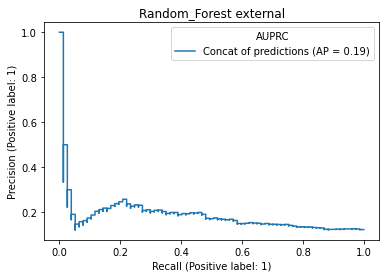

In [87]:
!mkdir 'Result/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset'
!mkdir 'Result/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/r_function_with_mannwhitney'
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    proteins_mannwhitney.to_numpy(), 
    label, 10, 'proteins', 'r_function_with_mannwhitney', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# Proteins mannwhitney + mrmr on whole dataset

('0.2348',
 '0.1673',
 RandomForestClassifier(criterion='entropy', n_estimators=500))

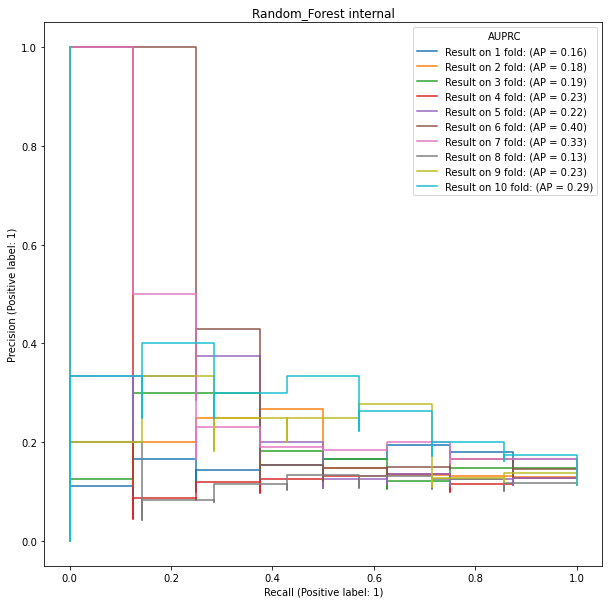

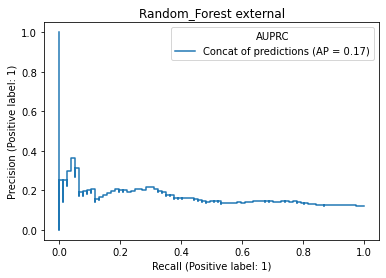

In [88]:
!mkdir 'Result/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/r_function_with_mannwhitney_mrmr'
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    proteins_mannwhitney_mrmr.to_numpy(), 
    label, 
    10, 
    'proteins', 
    'r_function_with_mannwhitney_mrmr', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# Proteins mannwhitney + boruta on whole dataset

('0.2447',
 '0.1746',
 RandomForestClassifier(max_features=None, max_leaf_nodes=5, n_estimators=51))

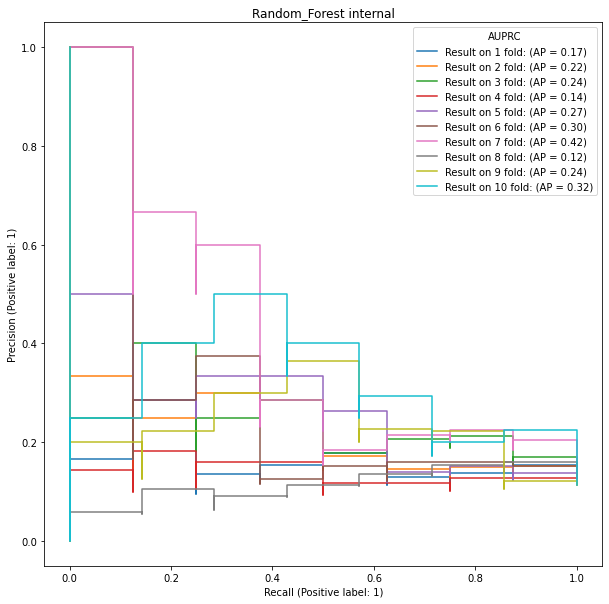

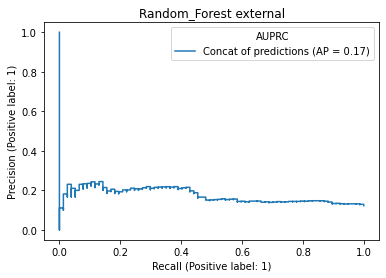

In [89]:
!mkdir 'Result/Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/r_function_with_mannwhitney_boruta'
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    proteins_mannwhitney_boruta.to_numpy(), 
    label, 
    10, 
    'proteins', 
    'r_function_with_mannwhitney_boruta', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# mRNA only mannwhitney on whole dataset

('0.2638',
 '0.1781',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=2, n_estimators=251))

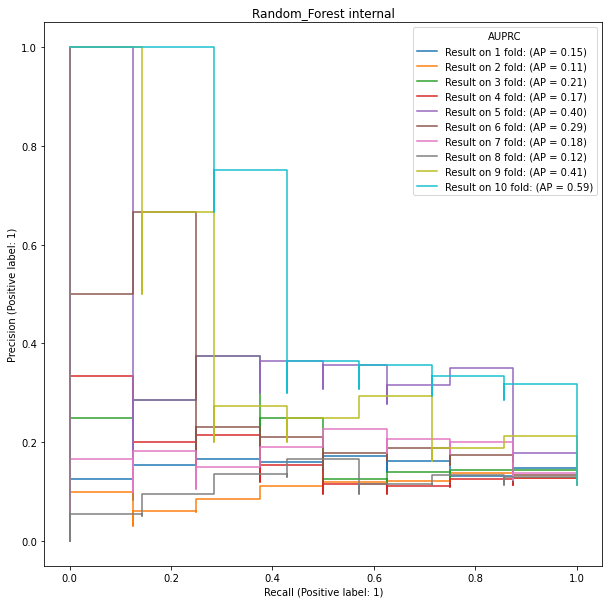

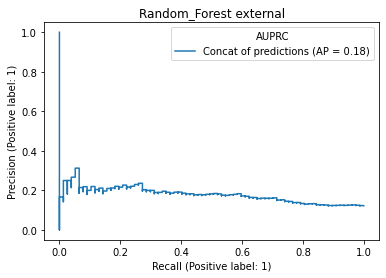

In [90]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    mrna_mannwhitney.to_numpy(), 
    label, 10, 'mrna', 'r_function_with_mannwhitney', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# mRNA mannwthiney + mrmr on whole dataset

train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    mrna_mannwhitney_mrmr.to_numpy(), 
    label, 
    10, 
    'mrna', 
    'r_function_with_mannwhitney_mrmr', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# mRNA mannwhitney + boruta on whole dataset

('0.3827',
 '0.2922',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=10, n_estimators=251))

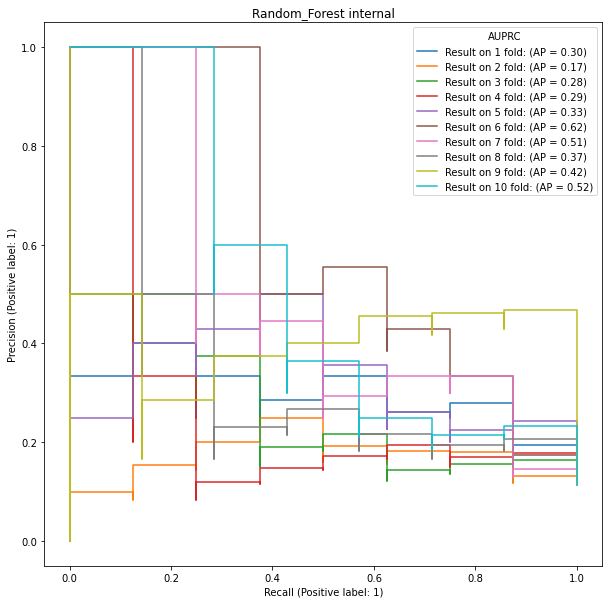

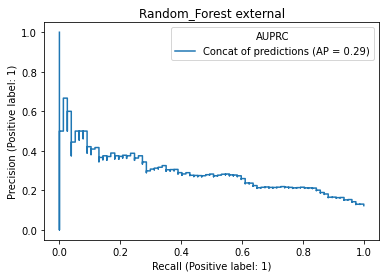

In [91]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    mrna_mannwhitney_boruta.to_numpy(), 
    label, 
    10, 
    'mrna', 
    'r_function_with_mannwhitney_boruta', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# miRNA only mannwhitney on whole dataset

('0.2228',
 '0.1774',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=5, n_estimators=101))

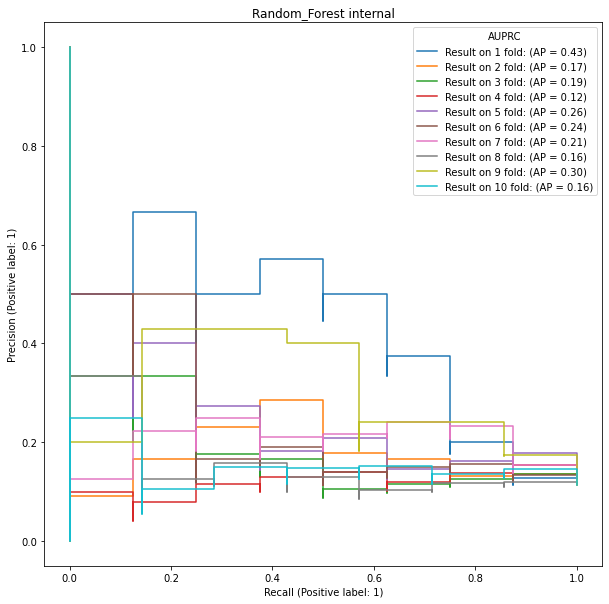

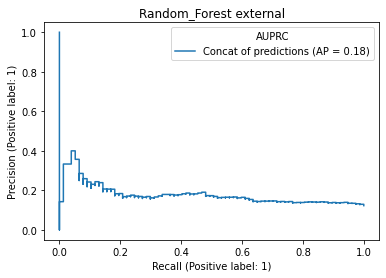

In [92]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    mirna_mannwhitney.to_numpy(), 
    label, 10, 'mirna', 'r_function_with_mannwhitney', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# miRNA mannwthiney + mrmr on whole dataset

('0.2532',
 '0.1798',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=5, n_estimators=101))

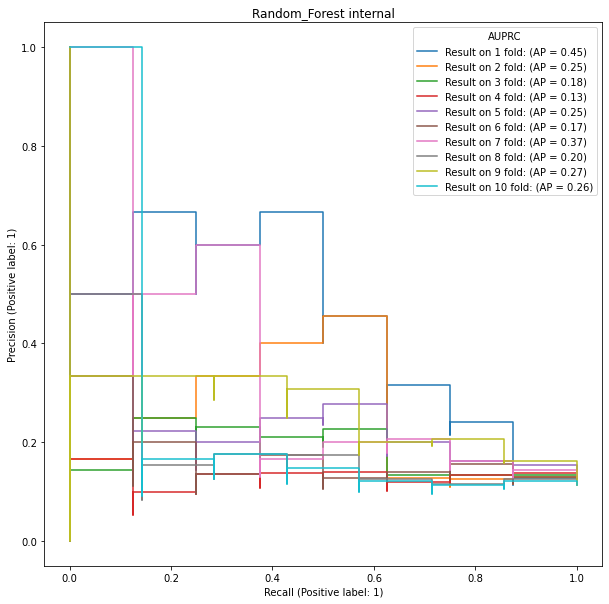

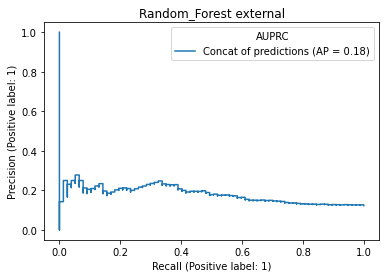

In [93]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    mirna_mannwhitney_mrmr.to_numpy(), 
    label, 
    10, 
    'mirna', 
    'r_function_with_mannwhitney_mrmr', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# miRNA mannwhitney + boruta on whole dataset

('0.2872',
 '0.1791',
 RandomForestClassifier(max_features='log2', max_leaf_nodes=5, n_estimators=51))

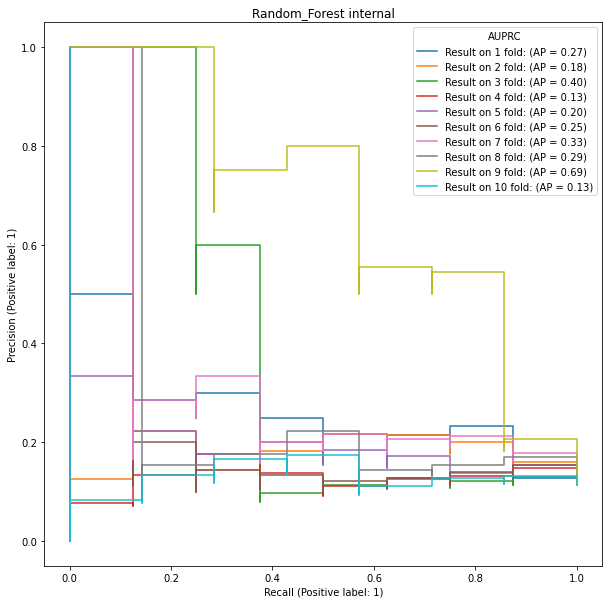

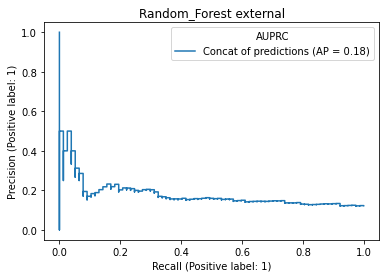

In [94]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    mirna_mannwhitney_boruta.to_numpy(), 
    label, 
    10, 
    'mirna', 
    'r_function_with_mannwhitney_boruta', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# cnv only mannwhitney on whole dataset

('0.2442',
 '0.1650',
 RandomForestClassifier(max_leaf_nodes=10, n_estimators=51))

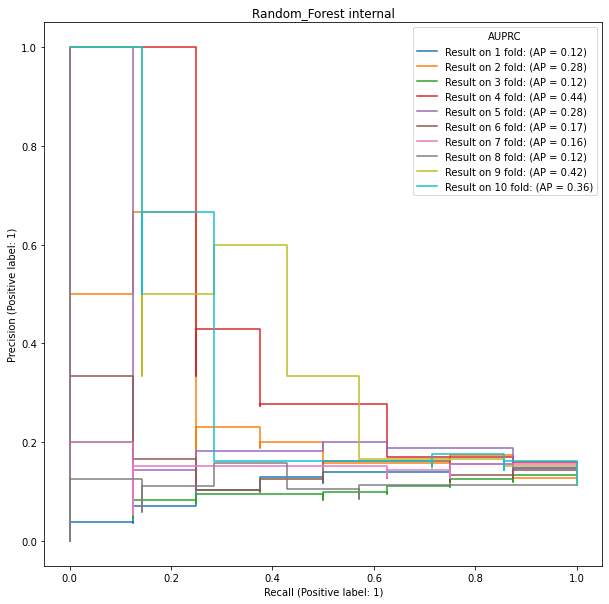

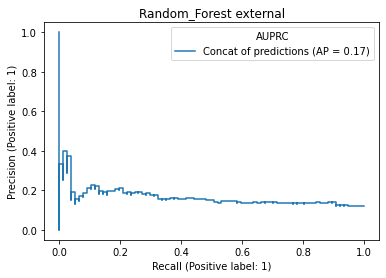

In [95]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    cnv_mannwhitney.to_numpy(), 
    label, 10, 'cnv', 'r_function_with_mannwhitney', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# cnv mannwthiney + mrmr on whole dataset

('0.2550',
 '0.1642',
 RandomForestClassifier(criterion='entropy', max_features=None, max_leaf_nodes=5,
                        n_estimators=51))

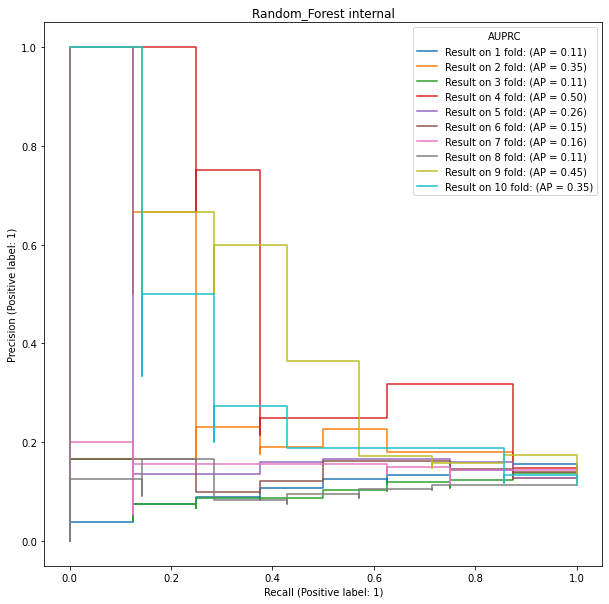

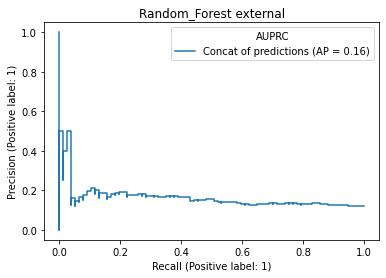

In [96]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    cnv_mannwhitney_mrmr.to_numpy(), 
    label, 
    10, 
    'cnv', 
    'r_function_with_mannwhitney_mrmr', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# cnv mannwthiney + boruta on whole dataset

('0.1875',
 '0.1385',
 RandomForestClassifier(max_features=None, max_leaf_nodes=10, n_estimators=101))

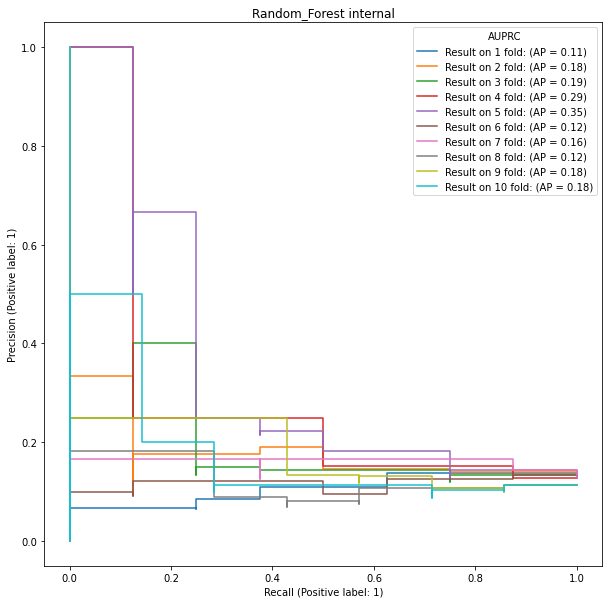

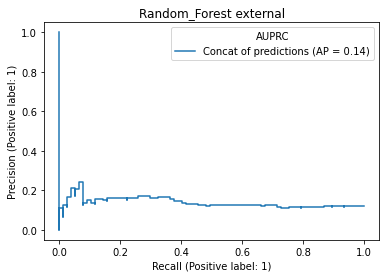

In [97]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    cnv_mannwhitney_boruta.to_numpy(), 
    label, 
    10, 
    'cnv', 
    'r_function_with_mannwhitney_boruta', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# Whole dataset (cnv+proteins+mirna+mrna) only mannwthiney on whole dataset

('0.2649',
 '0.1583',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=2, n_estimators=101))

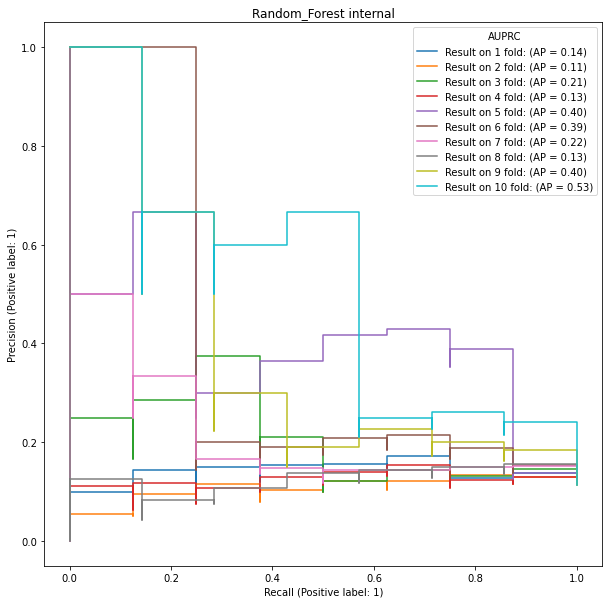

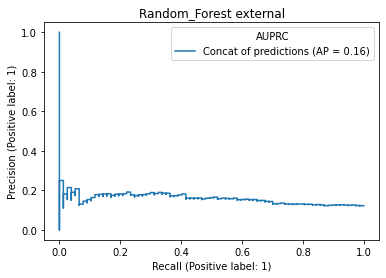

In [111]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    whole_mannwhitney.to_numpy(), 
    label, 10, 'whole_dataset', 'r_function_with_mannwhitney', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# Whole dataset (cnv+proteins+mirna+mrna) mannwthiney + mrmr on whole dataset

train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    whole_mannwhitney_mrmr.to_numpy(), 
    label, 
    10, 
    'whole_dataset', 
    'r_function_with_mannwhitney_mrmr', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# Whole dataset (cnv+proteins+mirna+mrna) mannwthiney + boruta on whole dataset

('0.3875',
 '0.3028',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=10, n_estimators=51))

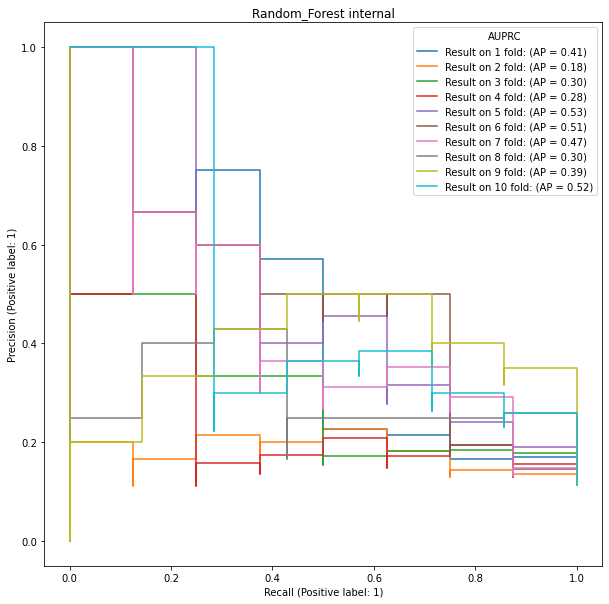

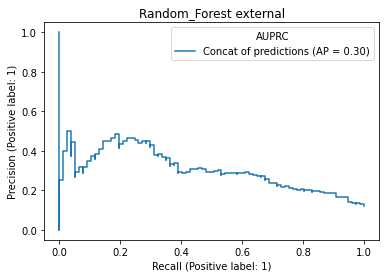

In [112]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    whole_dataset_mannwhitney_boruta.to_numpy(), 
    label, 
    10, 
    'whole_dataset', 
    'r_function_with_mannwhitney_boruta', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# Train proteins+mirna on whole dataset

('0.3119',
 '0.2077',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        n_estimators=251))

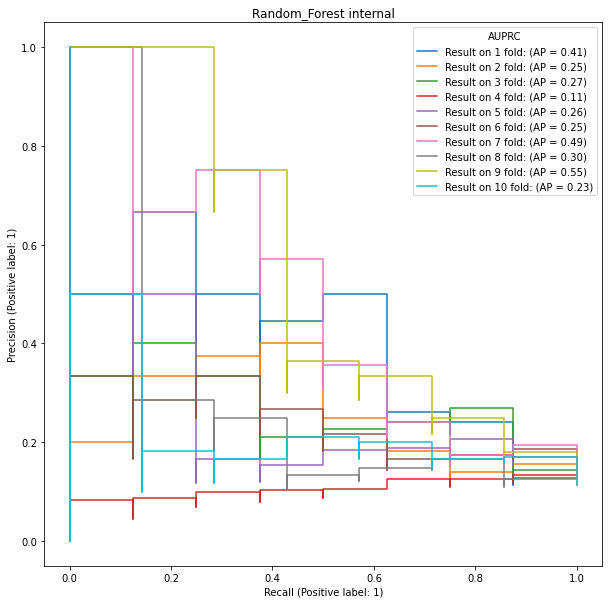

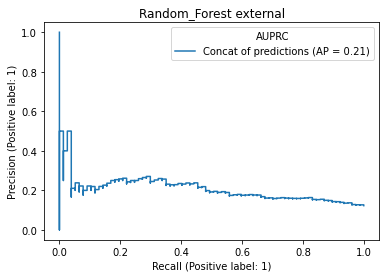

In [113]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    dataset_proteins_mirna_mannwhitney.to_numpy(), 
    label, 10, 'proteins_mirna', 'r_function_with_mannwhitney', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

('0.2870',
 '0.2151',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=10, n_estimators=251))

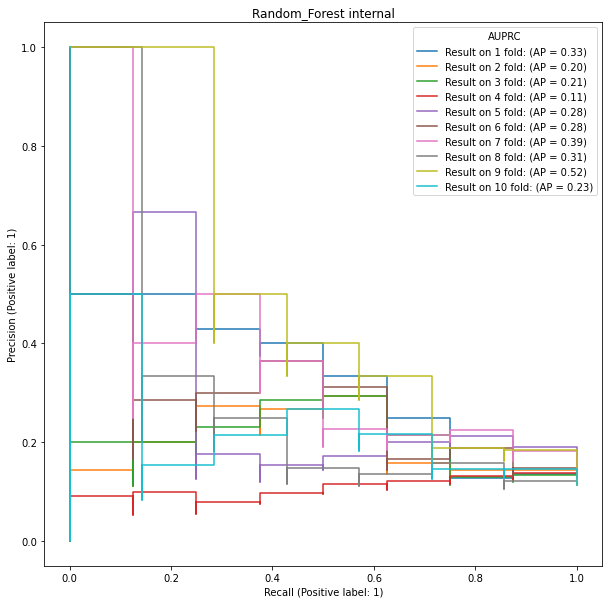

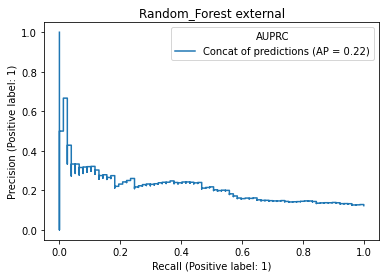

In [114]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    proteins_mirna_mrmr.to_numpy(), 
    label, 
    10, 
    'proteins_mirna', 
    'r_function_with_mannwhitney_mrmr', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

('0.3020',
 '0.2394',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=10, n_estimators=51))

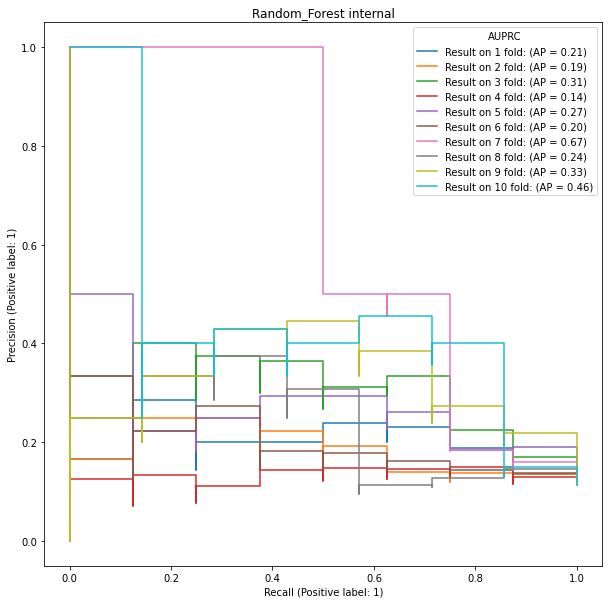

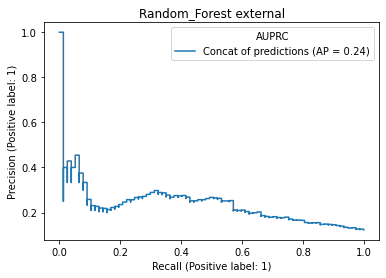

In [115]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    proteins_mirna_boruta.to_numpy(), 
    label, 
    10, 
    'proteins_mirna', 
    'r_function_with_mannwhitney_boruta', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

# Train proteins+mirna+mrna on whole dataset

('0.2483',
 '0.1732',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        max_leaf_nodes=2, n_estimators=51))

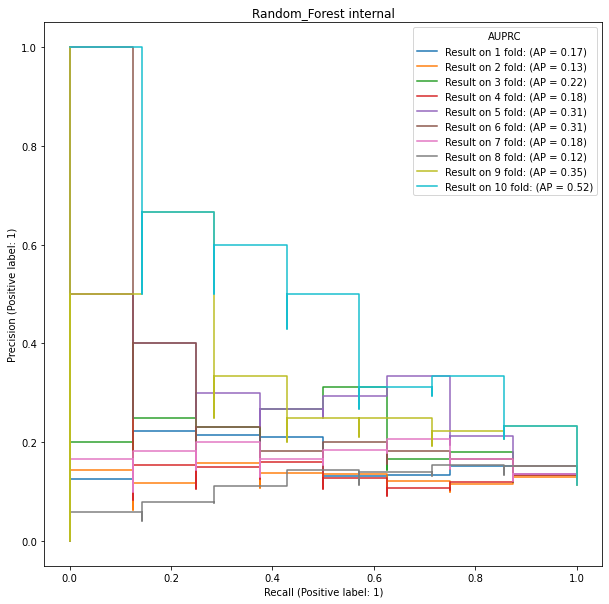

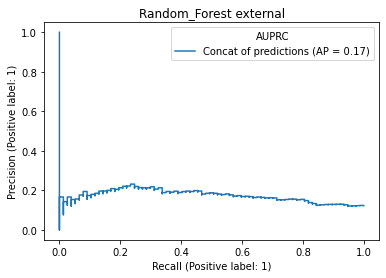

In [116]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    dataset_proteins_mirna_mrna_mannwhitney.to_numpy(), 
    label, 10, 'proteins_mirna_mrna', 'r_function_with_mannwhitney', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')

In [117]:
#too much time
'''train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    proteins_mirna_mrna_mrmr.to_numpy(), 
    label, 
    10, 
    'proteins_mirna_mrna', 
    'r_function_with_mannwhitney_mrmr', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')'''

"train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(\n    proteins_mirna_mrna_mrmr.to_numpy(), \n    label, \n    10, \n    'proteins_mirna_mrna', \n    'r_function_with_mannwhitney_mrmr', \n    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')"

('0.3804',
 '0.3242',
 RandomForestClassifier(criterion='entropy', n_estimators=51))

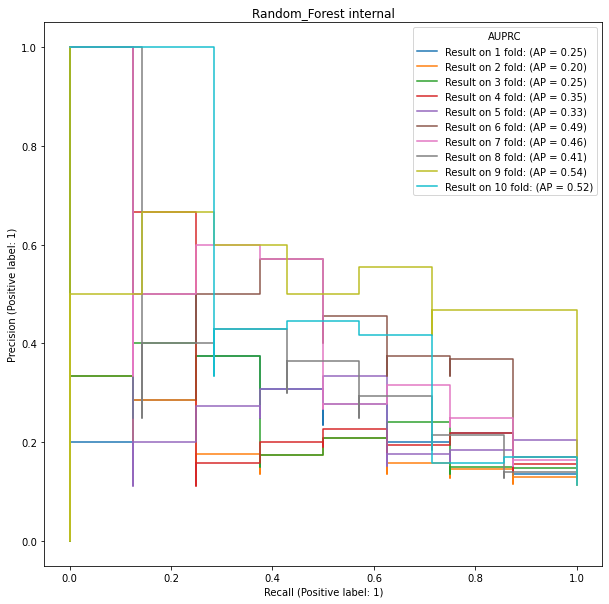

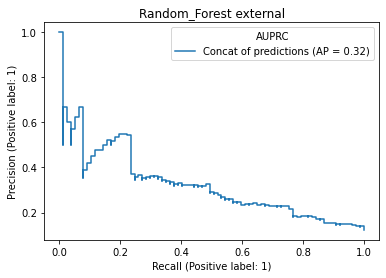

In [118]:
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(
    proteins_mirna_mrna_boruta.to_numpy(), 
    label, 
    10, 
    'proteins_mirna_mrna', 
    'r_function_with_mannwhitney_boruta', 
    'Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')